# IML Assignment 2 - Roshni Pai, Vatsl Goswami

## 1. Introduction
### Explaining the Dataset
The _Synthetic Circles_ data-set is a structured dataset containing:
- *Instances*: 10,000
- *Features*: 2

All the datapoints are divided into 100 'hollow' circles. These form a *non-convex* shape over $\mathbb{R}^2$, and thus provide insight into how different clustering algorithms perform.

### Objective
The objective of this notebook is to get a hands-on experience with:
- Exploring the dataset
- Performing different pre-processing techinques
- Writing clustering algorithms from scratch
- Choosing the right hyper-parameters by testing
- Evaluating the performance of our models using metrics like DB-Index and Silhouette Scores.

Our focus is not on *achieving the best results* but ensuring we follow the *correct process*. As a result, at many points in our code, we've made the decision to not tweak our models just to achieve better metrics, but rather according to the methods (for e.g., Elbow Method) prescribed in lectures. Hopefully, our sincerity comes through as you follow-along our code. 

## 2. Exploratory Data Analysis

### Basic Data Checks
2. Exploratory Data Analysis (EDA)
   -  Summarize the datasets: number of samples, features, data types, missing values.
   -  Visualize important feature distributions and correlations.
   -  Identify any potential data quality issues.

In [82]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pltc
from IPython.display import display
import random
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import adjusted_rand_score

In [83]:
# Loading the dataset and printing the shape
df = pd.read_csv("data/dataset1.txt")

display(df.head())
print(df.shape)

,x,y,class
0,3.15676,116.12252,6
1,16.14436,16.81660,11
2,100.31212,64.99025,53
3,-1.33773,84.81772,4
4,104.37328,62.42373,53


(10000, 3)


In [84]:
#Understanding the data-types
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       10000 non-null  float64
 1   y       10000 non-null  float64
 2   class   10000 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 234.5 KB
None


In [85]:
# Checking for null-values
display(df.isnull().sum())
display(df.duplicated().sum())

x        0
y        0
class    0
dtype: int64

np.int64(0)

In [86]:
# Calculating measures of central tendency
df.describe()

,x,y,class
count,10000.000000,10000.000000,10000.000000
mean,89.981670,90.003827,49.500000
std,57.457467,57.559719,28.867513
min,-5.000000,-4.999860,0.000000
25%,40.237885,40.133840,24.750000
50%,89.999995,90.000080,49.500000
75%,139.898800,139.977695,74.250000
max,184.999920,185.000000,99.000000


### Results of above code:
We can see that the dataset has the following features:
- *Instances*: 10,000
- *Features*: 2 --- we are given coordinates of points $(x,y)$ where both features are floats, i.e. they belong to $\mathbb{R}$.
- *Nulls & Duplicates*: Since the data is synthetically generated, there are **no null and duplicate** values that we will need to separately handle.

### Visualising the Dataset

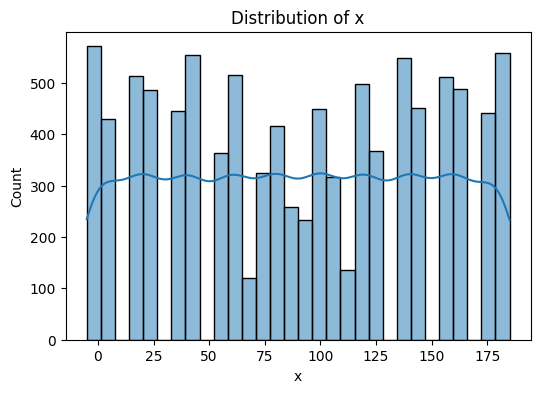

KeyboardInterrupt: 

In [87]:
# Plotting the distribution of x, y
for col in df.columns:
    if col == "class":
        continue
    plt.figure(figsize=(6,4))
    sns.histplot(data=df, x=col, kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

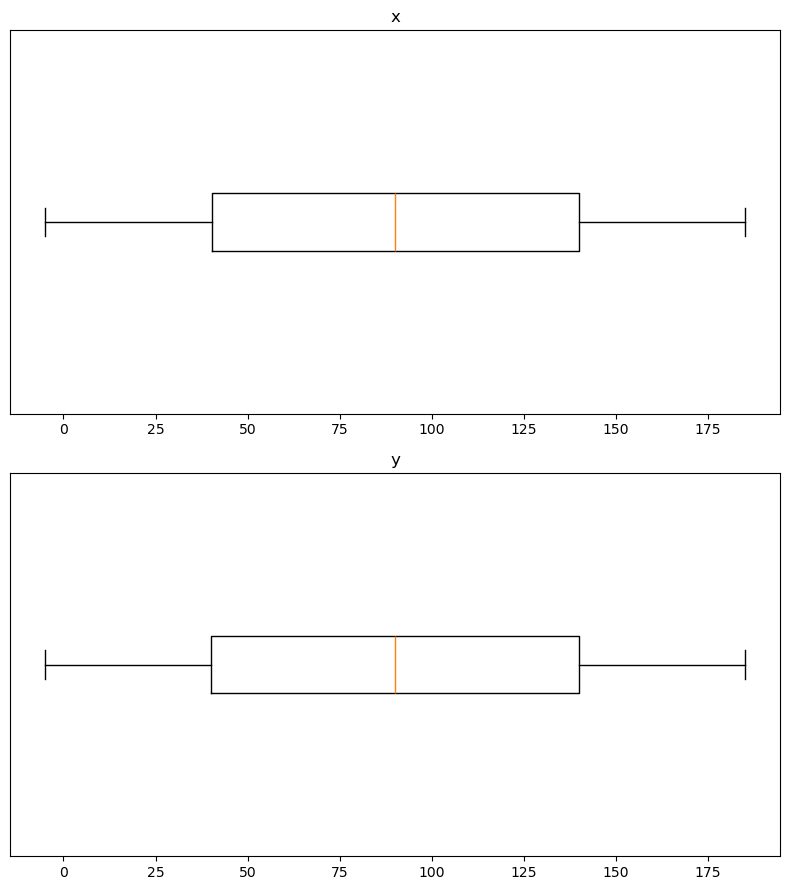

In [ ]:
# Box-plots of x,y to check for any outliers

fig, axs = plt.subplots(len(df.columns)-1, 1, figsize=(8, 3*len(df.columns)), dpi=100)

if len(df.columns) == 1:
    axs = [axs]

for i, col in enumerate(df.columns):
    if col=="class":
        continue
    axs[i].boxplot(df[col].dropna(), vert=False)
    axs[i].set_title(col)   
    axs[i].set_yticks([]) 

plt.tight_layout()
plt.show()

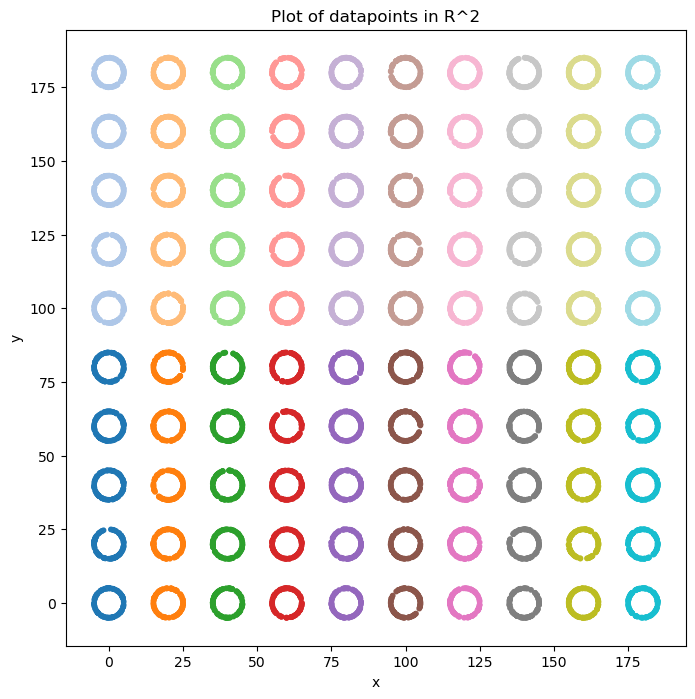

In [ ]:
# Scatter plot of all our data-points in R^2

plt.figure(figsize = (8,8))
plt.scatter(df["x"], df["y"],c=df['class'], cmap="tab20", s=10)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Plot of datapoints in R^2")
plt.show()

### Results of above code:
From the above histogram & box plots, we can see that:
- $x,y$ are evenly distributed and have **no outliers**.
- Our dataset forms multiple non-convex, hollow circle shaped clusters in $\mathbb{R}^2$. Thus, this creates a **conflict** with the assumptions of algorithms like `kMeans` and `GMMs`, which assume that our clusters form dense, spherical blobs.
- *Hypothesis*: density-based algorithms like `DBScan` will work much better in representing our dataset than `kMeans/GMM`.

## 3. Data-Preprocessing
Since the data has no categorical variables, null/duplicate values, the only pre-processing step we need to follow is *standardization of our input features.* This ensures that all the inputs are centred around 0, which is very important for algorithms that rely on Euclidean distances to decide cluster membership.

In [ ]:
# Splitting our input and output columns
X = df[["x", "y"]].copy()
y = df['class'].copy()

In [ ]:
# Performing z-score normalization on our inputs

def standardize(col):
    mu = X[col].mean()
    sigma = X[col].std()
    X.loc[:, col] = (X[col] - mu)/sigma

for col in X.columns:
    standardize(col)

display(X.head())

,x,y
0,-1.511116,0.453767
1,-1.285078,-1.271501
2,0.179793,-0.434567
3,-1.589339,-0.090100
4,0.250474,-0.479156


## 4. Clustering Methods
### Algo 1: K-Means Clustering

In [ ]:
# func to calculate euclidean distance between two points.
def norm(p1, p2):
    return sqrt((p2['x']-p1['x'])^2 + (p2['y']-p1['y'])^2)

In [ ]:
# k-means clustering
def k_means(X, k, max_iter=20, tol=1e-5, random_state=None):
    # setting up numpy random number generator to sample our initial k-centroids
    rng = np.random.default_rng(seed=random_state)

    n_samples = X.shape[0]
    n_features = X.shape[1]
   
    # Step 1: Initialize centroids (random sample of k points)
    idx = rng.choice(n_samples, size=k, replace=False)
    centers = X[idx, :]
    # this will store values of J (Within Cluster SSE) for each iteration -- useful to plot gradient descent
    obj_func = []

    for iteration in range(max_iter):
        # Step 2: Assign points to nearest centroid
        dists = np.linalg.norm(X[:, None, :] - centers[None, :, :], axis=2) 
        labels = np.argmin(dists, axis=1)  # nearest centroid for each point

        # Step 2b: Calculate objective (WCSS)
        J = np.sum((X - centers[labels])**2)
        obj_func.append(J)

        # Step 3: Recompute centroids
        new_centers = np.zeros_like(centers)
        for cluster_idx in range(k):
            members = X[labels == cluster_idx]
            if len(members) > 0:
                new_centers[cluster_idx] = members.mean(axis=0)
            else:
                # reinitialize cluster if empty
                new_centers[cluster_idx] = X[rng.integers(0, n_samples)]

        # Check if we have converged
        shift = np.linalg.norm(new_centers - centers)
        if shift < tol:
            centers = new_centers
            break

        centers = new_centers

    return centers, labels, obj_func

### Choosing `max-iter`, `tol`
We plot the graph of $J$ over our iterations to see at which iteration our algorithm stops improving. From the plot below, we can see clearly that **after the 20th iteration* we do not make any improvements in our objective function $J$.  

**_Choice of hyper-param_**: Set `max_iter` = 20   
Set `tol` = $1^{-5}$  because that is the industry-standard for standardized data. Regardless, our function will stop according to our `max_iter` value before it converges according to the `tol`.

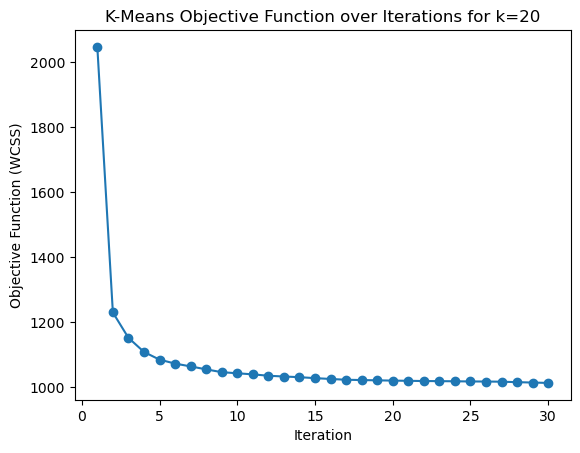

In [ ]:
k = 20
centers, labels, objectives = k_means(X, k=k, max_iter = 30)

plt.plot(range(1, len(objectives)+1), objectives, marker = 'o')
plt.xlabel("Iteration")
plt.ylabel("Objective Function (WCSS)")
plt.title(f"K-Means Objective Function over Iterations for k={k}")
plt.show()

### Choosing `k` (no. of clusters) using Elbow Method
While we know that our dataset is divided into 100 seperate circles (clusters). This value of $k$ need not necessarily provide the best clustering for our `kMeans` algorithm. This is primarily because as explained before, the algorithm only works for convex clusters.

Hence, we choose the best value of `k` using the *Elbow Method*. Here, we plot the WCSS for $k \in [1, 200]$ and see at which point we get diminishing returns. That is, choosing the elbow point value for $k$ gives us the best trade-off between maximizing the cluster density along with not choosing too small cluster sizes.

In our data, we can see the data has an elbow point near 25. Thus, we choose our hyperparameter `k` = 30.

In [ ]:
inertias = []
for k in range(1, 200):
    centers, labels, objectives = k_means(X, k=k)
    inertias.append(objectives[-1])
    print(f"Inertia done for k={k}")

Inertia done for k=1
Inertia done for k=2
Inertia done for k=3
Inertia done for k=4
Inertia done for k=5
Inertia done for k=6
Inertia done for k=7
Inertia done for k=8
Inertia done for k=9
Inertia done for k=10
Inertia done for k=11
Inertia done for k=12
Inertia done for k=13
Inertia done for k=14
Inertia done for k=15
Inertia done for k=16
Inertia done for k=17
Inertia done for k=18
Inertia done for k=19
Inertia done for k=20
Inertia done for k=21
Inertia done for k=22
Inertia done for k=23
Inertia done for k=24
Inertia done for k=25
Inertia done for k=26
Inertia done for k=27
Inertia done for k=28
Inertia done for k=29
Inertia done for k=30
Inertia done for k=31
Inertia done for k=32
Inertia done for k=33
Inertia done for k=34
Inertia done for k=35
Inertia done for k=36
Inertia done for k=37
Inertia done for k=38
Inertia done for k=39
Inertia done for k=40
Inertia done for k=41
Inertia done for k=42
Inertia done for k=43
Inertia done for k=44
Inertia done for k=45
Inertia done for k=

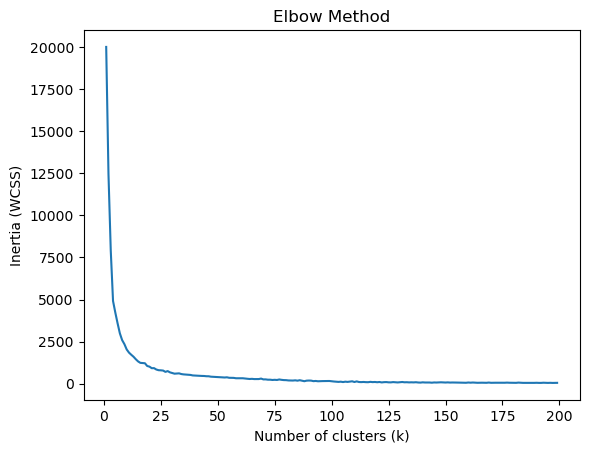

In [ ]:
ks = range(1, len(inertias) + 1)

plt.plot(ks, inertias)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method")
plt.show()

## Visualizing the Results

Running `kMeans` on our dataset, for $k=30$, we see that the model ends up clustering multiple circles into 1 cluster. Roughly $3-4$ circles get grouped together. This is much better than what would happen for larger values of $k$, where the algorithm would divide the circle into weird partitions since our centroids could never get updated to reach the center of each circle (becuse no datapoints exist inside our rings).

Below is a clear visualization of our data in $\mathbb{R}^2$. The cross-marks represent the centroids for each number/label.

In [ ]:
#Choose k = 30 and max_iter = 30 based on graphs above
k = 30
max_iter = 30
centers, labels_kmeans, objectives = k_means(X, k=k, max_iter = max_iter)

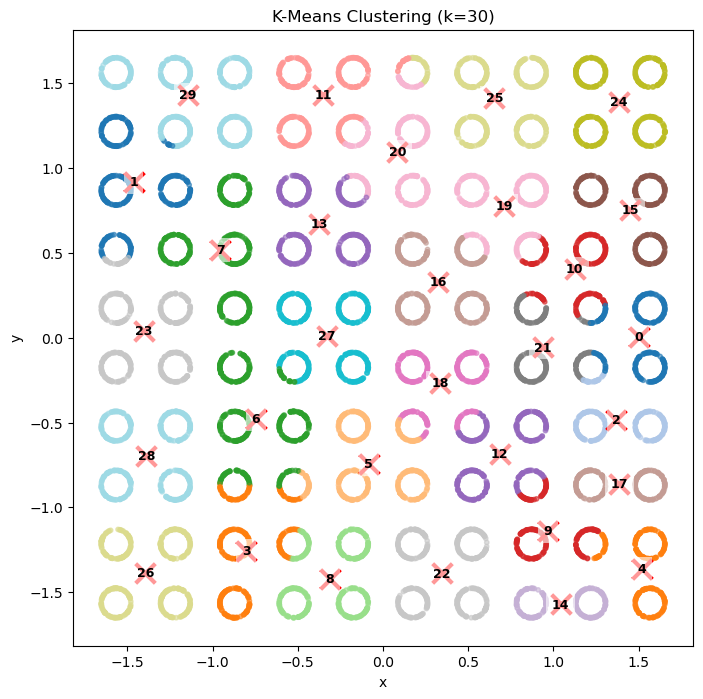

In [ ]:
plt.figure(figsize=(8,8))

# Scatter plot colored by cluster labels
plt.scatter(X[:,0], X[:,1], c=labels_kmeans, cmap='tab20', s=10, alpha=0.6)

# Overlay centroids as large red X's
plt.scatter(centers[:,0], centers[:,1], c='red', marker='x', s=200, linewidths=3)


# Annotate each centroid with its cluster ID
for idx, (cx, cy) in enumerate(centers):
    plt.text(cx, cy, str(idx), fontsize=9, fontweight = "bold", color='black',
             ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.title(f"K-Means Clustering (k={k})")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Performance Metrics of `kMeans`

As expected, our `kMeans` algorithm does not provide a very good clustering of this dataset. Clearly, it is unable to capture the data's weird structure.

The **Silhouette Score** is $0.36$. This is primarily because of the large intra-cluster distances between the circles that actually belong to separate classes in our original labelling.

The high **DB-Index** of $0.85$ also suggests the clustering is not great.

We also tested using the **Adjusted-Rand Index** since we were given the labels for each class. A score of $0.4$ suggests the data retains a decent amount of the original structure---but there is lot of scope for improvement.

In [ ]:
score = silhouette_score(X, labels_kmeans)
print(f"Silhouette Score: {score}")

score = davies_bouldin_score(X, labels_kmeans)
print(f"DB-Index: {score}")

ari = adjusted_rand_score(y, labels_kmeans)
print(f"Adjused-Rand Index: {ari}")

Silhouette Score: 0.3624636849521206
DB-Index: 0.8523002535275256
Adjused-Rand Index: 0.39214263535750177


### Algo 2: DBScan

In [ ]:
# finding all points within an epsilon distance of p= X[idx]
def find_neighbors(X, idx, eps):
    dist = np.linalg.norm(X-X[idx], axis=1)
    return np.where(dist<=eps)[0]

def dbscan(X, minPts=4, eps=2):
    n = X.shape[0] #total number of datapoints

    #define labels for unvisited and noise
    unvisited = -2 
    noise = -1
    labels = np.full(n, unvisited, dtype=int)
    cluster_id = 0

    for i in range(n):

        if labels[i] != unvisited:
            continue #point was already processed

        neighbors = find_neighbors(X, i, eps)

        # not a core point (enough to start a new cluster)
        if neighbors.size < minPts:
            labels[i] = noise
            continue
            
        #if a core point, start a new cluster
        cluster_id += 1
        labels[i] = cluster_id
        pts_to_check = [i for i in neighbors]

        #explore all the points neighbors for potential members of the new cluster
        while pts_to_check:
            j = pts_to_check.pop()
            
            if labels[j] == noise:
                labels[j] = cluster_id #non-core pts become borders of our cluster but cannot expand the cluster

            if labels[j] != unvisited:
                continue 
                
            labels[j] = cluster_id
            j_neighbors = find_neighbors(X, j, eps)

            #if j is a core-point, add its neighbors to our pts_to_check
            if j_neighbors.size >= minPts:
                for nb in j_neighbors:
                    if labels[nb] in [unvisited, noise]:   
                        pts_to_check.append(nb)
    return labels     
        

### Choosing `eps` using Elbow Method
Once again, we use the Elbow Method to choose the parameter `eps`. To do this, we first fix our `minPts` to values roughly $~ 2\cdotD$ where D is the no. of dimensions. This is gives us a range of the no. of points we want to consider to be a core point. The number is proportional to the dimensions of our input-space since the larger our input space gets, the more sparse our data. Thus, we need more points to define a dense region/cluster.

Using this, we plot the max-distance of the epsilon neighbors of all our points. The elbow of this graph, gives us a good, efficient value of `eps`, which can be used to define clusters.

From our graphs, we choose eps-values as follows (on right), along with their corresponding minPts value (in the left side):
- $4 \rightarrow \epsilon = 0.0175$
- $5\rightarrow \epsilon = 0.021$
- $6\rightarrow \epsilon = 0.025$
- $7\rightarrow \epsilon = 0.03$
- $8 \rightarrow \epsilon = 0.034$


In [ ]:
minPts = [4,5,6,7,8]
def plot_elbow_DBSCAN(n_neighbors):
    k = n_neighbors
    nbrs = NearestNeighbors(n_neighbors = k).fit(X)
    distances, idx = nbrs.kneighbors(X)

    kdist = distances[:, -1]
    kdist_sorted = np.sort(kdist)[::-1]

    plt.figure(figsize=(6,4))
    plt.plot(kdist_sorted)
    plt.xlabel("Points (sorted)")
    plt.ylabel(f"{k}-NN distance")
    plt.title(f"k-distance elbow plot (minPts={k})")
    plt.grid(alpha=0.3)
    plt.show()

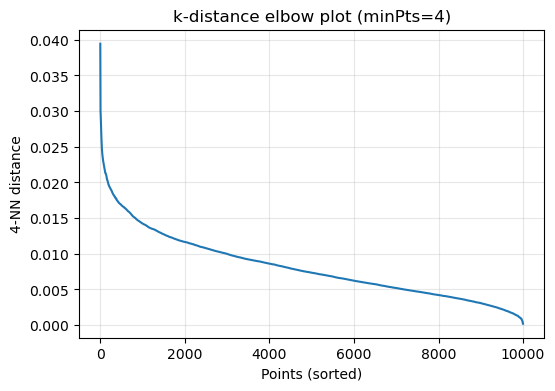

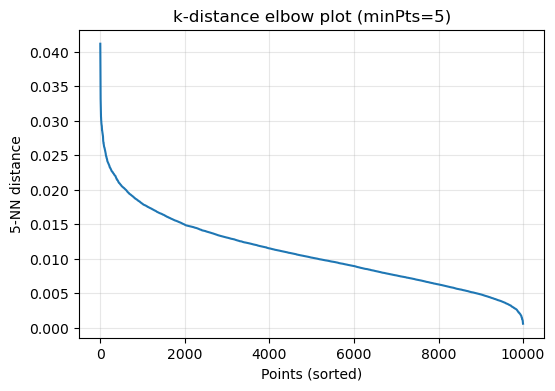

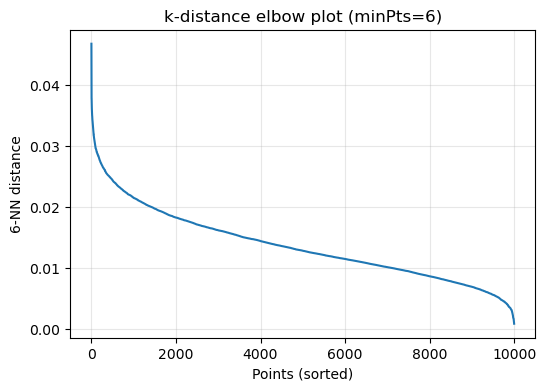

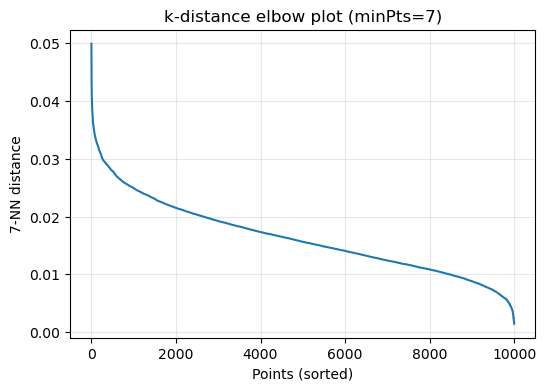

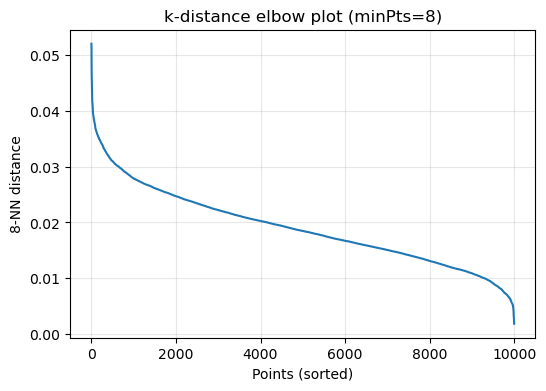

In [ ]:
for minPt in minPts:
    plot_elbow_DBSCAN(minPt)

### Choosing `minPts`
We now check the Silhouette Scores of our `DBSCAN` for our chosen values of `minPts` and their corresponding fixed $\epsilon$ values. Now, choose the pair hwich gives us the best Silhouette Score.

Thus, we choose: `minPts` $= 8$, `eps` $= 0.034$ 


In [ ]:
minpts_eps = {
    4: 0.0175,
    5: 0.021,
    6: 0.025,
    7: 0.03,
    8: 0.034
}

for minPt, eps in minpts_eps.items():
    labels = dbscan(X, minPt, eps)
    print(f"Silhouette Score for minPts={minPt}: {(silhouette_score(X,labels))}")

Silhouette Score for minPts=4: 0.39532746950426684
Silhouette Score for minPts=5: 0.4137459716483472
Silhouette Score for minPts=6: 0.4569009878656834
Silhouette Score for minPts=7: 0.5658560465519425
Silhouette Score for minPts=8: 0.5913940933181553


### Visualizing the Results

The plots below show us that the DBSCAN algorithm understands the non-convex structure of our dataset much better. It identifies **107** clusters, much closer to the original $100$, and also labels larger portions of the circles into 1 cluster. 

In [ ]:
minpts = 8
eps = 0.034
labels_dbscan_new = dbscan(X, minPts=minpts, eps=eps)

# unique labels
unique_labels = np.unique(labels_dbscan_new)

# exclude noise (-1)
n_clusters = len(unique_labels[unique_labels != -1])
n_noise = np.sum(labels_dbscan== -1)

print("Clusters found:", n_clusters)
print("Noise points:", n_noise)

Clusters found: 107
Noise points: 8


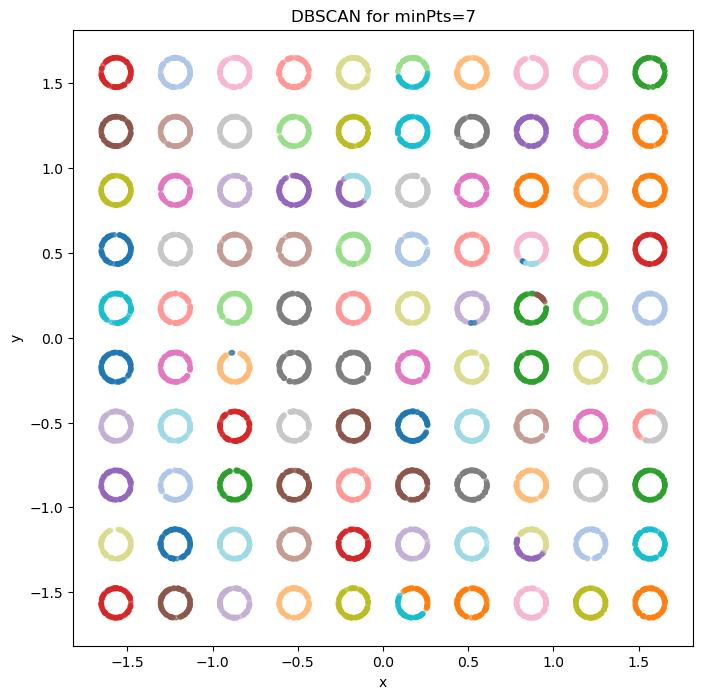

In [ ]:
plt.figure(figsize=(8,8))

# Scatter plot colored by cluster labels
plt.scatter(X[:,0], X[:,1], c=labels_dbscan_new, cmap='tab20', s=10, alpha=0.6)

plt.title(f"DBSCAN for minPts=7")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

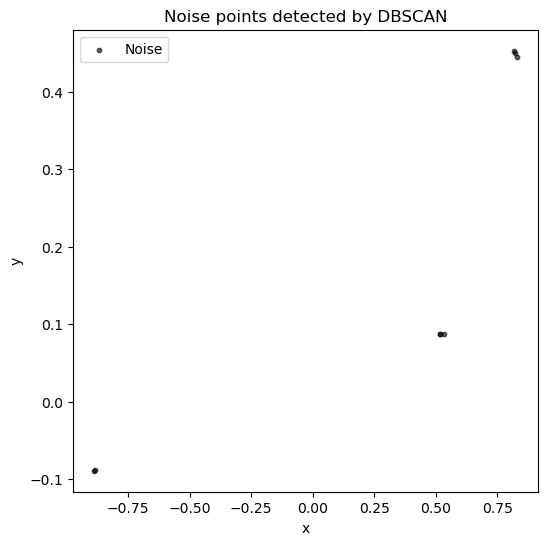

In [ ]:
# Get noise points (labels == -1)

noise_points = X[labels_dbscan_new == -1]

plt.figure(figsize=(6,6))

# plot noise points only
plt.scatter(noise_points[:,0], noise_points[:,1], c='black', s=10, alpha=0.6, label="Noise")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Noise points detected by DBSCAN")
plt.legend()
plt.show()

## Performance Metrics
Clearly, DBScan creates more *well-formed* clusters as reflected in it's higher **Silhouette Score** and lower **DB Index**.

The algorithm also does **amazing** in retrieving the original labels of our dataset. This is seen in its almost perfect **Rand-Index** of $0.98$.

In [ ]:
#Masking noise points to get clearer picture of clustering metrics

mask = labels_dbscan_new != -1
labels_eval = labels_dbscan_new[mask]
X_eval = X[mask]

sil_score = silhouette_score(X_eval, labels_eval)
print(f"Silhouette Score: {sil_score}")

db_score = davies_bouldin_score(X_eval, labels_eval)
print(f"DB-Index: {db_score}")

ari = adjusted_rand_score(y[mask], labels_eval)
print(f"Adjusted-Rand Index: {ari}")

Silhouette Score: 0.592567059420955
DB-Index: 0.5632768587603503
Adjusted-Rand Index: 0.9842376665976712


## Why does DBSCAN do better than kMeans for this Dataset?
DBSCAN performs much better than kMeans for this dataset because of the following reasons:
- *Each cluster has roughly the same density.* Hence, our single choice of `eps` works very well in clustering all the different circles.
- *The clusters are non-convex*. `kMeans` assumes clusters are convex. Meanwhile, `DBSCAN` simply clusters data based on density of points. Hence, it works better for all kinds of shapes compared to `kMeans`.
- *Input space has low dimensionality*. `kMeans` is simple and thus can work well even in larger-dimensional spaces. Meanwhile, as the dimensionality increases, the datapoints become more sparse and hence density-based algorithms like `DBSCAN` would **struggle to define clusters**. 

## Dimensionality Reduction:
Since the task at hand is an unsupervised clustering task, it doesn't make sense to use `LDA`--as it maximizes variance along class labels. Thus, we decided to go ahead with dimensionality reduction using `PCA` in the following ways:
- Perform a change of basis in $\mathbb{R}^2$ itself and see how it affects clustering performance.
- Perform reduction to $dim = 1$ and see how it affects clustering performance.

Another thing to note is that, since our input space was already only 2-dimensional, dimensionality reduction is not as useful of a tool to this dataset. This is further supplemented by the fact that reducing our dataset to 1D means losing the inherent circular structure of our datapoints...Regardless, below are the results of our exploration.

### Part 1: PCA into 2D

PCA(2) explained variance ratio: [0.50050531 0.49949469]
PCA(1) explained variance ratio: [0.50050531]


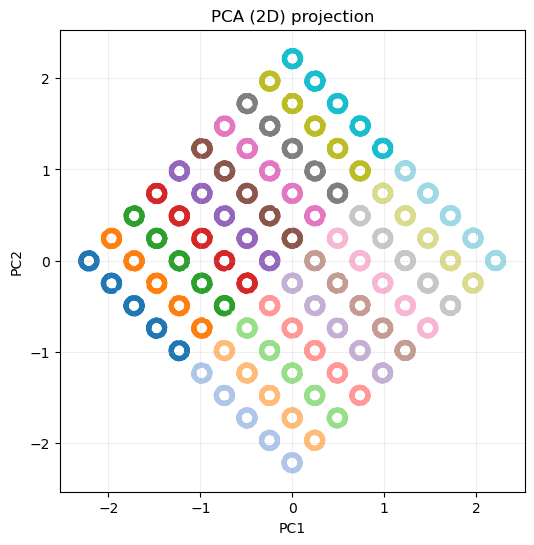

In [ ]:
# Plotting graph of our transformed 2-D space

pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X)
print("PCA(2) explained variance ratio:", pca2.explained_variance_ratio_)

# 1D reduction
pca1 = PCA(n_components=1)
X_pca1 = pca1.fit_transform(X).ravel()
print("PCA(1) explained variance ratio:", pca1.explained_variance_ratio_)


# 3a) 2D PCA scatter
plt.figure(figsize=(6,6))

plt.scatter(X_pca2[:,0], X_pca2[:,1], c=df['class'], cmap="tab20", s=8, alpha=0.7)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (2D) projection")
plt.grid(alpha=0.2)
plt.show()

Clearly, we can see that the graph has only been rotated into a direction that organizes the data into a diamond shape. This does not change the density of our clusters and thus will have **no effect** on an algorithm like `DBSCAN`.  

Similarly, the orientation of our rings does not change with a rotation by 45 degrees and thus, we will not see any change in our `kMeans` function either.

In [ ]:
minpts = 8
eps = 0.034
labels_dbscan_pca2 = dbscan(X_pca2, minPts=minpts, eps=eps)

# unique labels
unique_labels = np.unique(labels_dbscan_pca2)

# exclude noise (-1)
n_clusters = len(unique_labels[unique_labels != -1])
n_noise = np.sum(labels_dbscan_pca2== -1)

print("Clusters found:", n_clusters)
print("Noise points:", n_noise)

Clusters found: 107
Noise points: 8


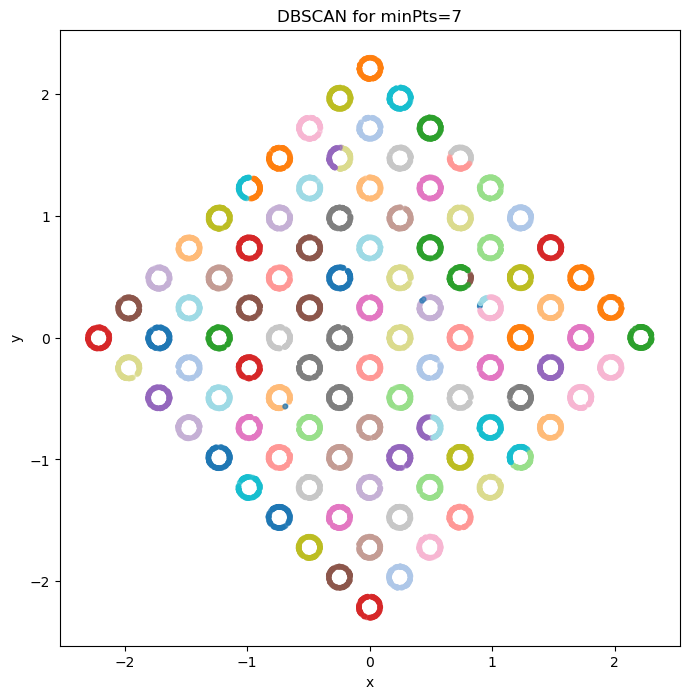

In [ ]:
plt.figure(figsize=(8,8))

# Scatter plot colored by cluster labels
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=labels_dbscan_pca2, cmap='tab20', s=10, alpha=0.6)

plt.title(f"DBSCAN for minPts=7")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

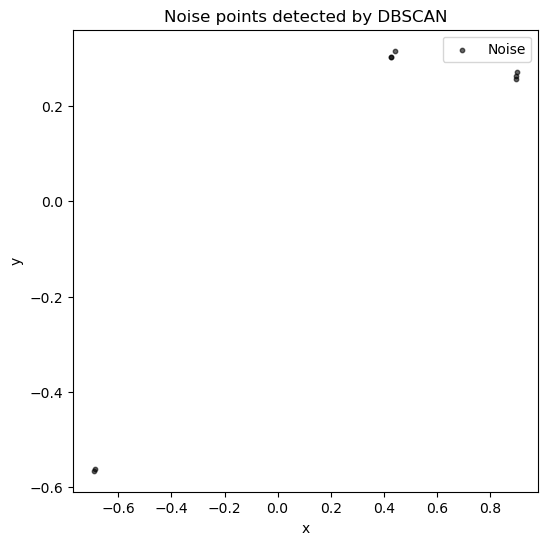

In [ ]:
# Get noise points (labels == -1)
noise_points = X_pca2[labels_dbscan_pca2 == -1]

plt.figure(figsize=(6,6))

# plot noise points only
plt.scatter(noise_points[:,0], noise_points[:,1], c='black', s=10, alpha=0.6, label="Noise")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Noise points detected by DBSCAN")
plt.legend()
plt.show()

In [ ]:
#Masking noise points to get clearer picture of clustering metrics.
mask = labels_dbscan_pca2 != -1
labels_eval_pca2 = labels_dbscan_pca2[mask]
X_eval_pca2 = X_pca2[mask]

sil_score = silhouette_score(X_eval_pca2, labels_eval_pca2)
print(f"Silhouette Score: {sil_score}")

db_score = davies_bouldin_score(X_eval_pca2, labels_eval_pca2)
print(f"DB-Index: {db_score}")

ari = adjusted_rand_score(y[mask], labels_eval_pca2)
print(f"Adjusted-Rand Index: {ari}")

Silhouette Score: 0.5925670594209552
DB-Index: 0.5632768587603517
Adjusted-Rand Index: 0.9842376665976712


As we can see above, `DBSCAN` clusters the data in roughly the same way as before and there is no change in the performance either.

In [ ]:
#Choose k = 30 and max_iter = 30 based on graphs above
k = 30
max_iter = 30
centers, labels_kmeans, objectives = k_means(X_pca2, k=k, max_iter = max_iter)

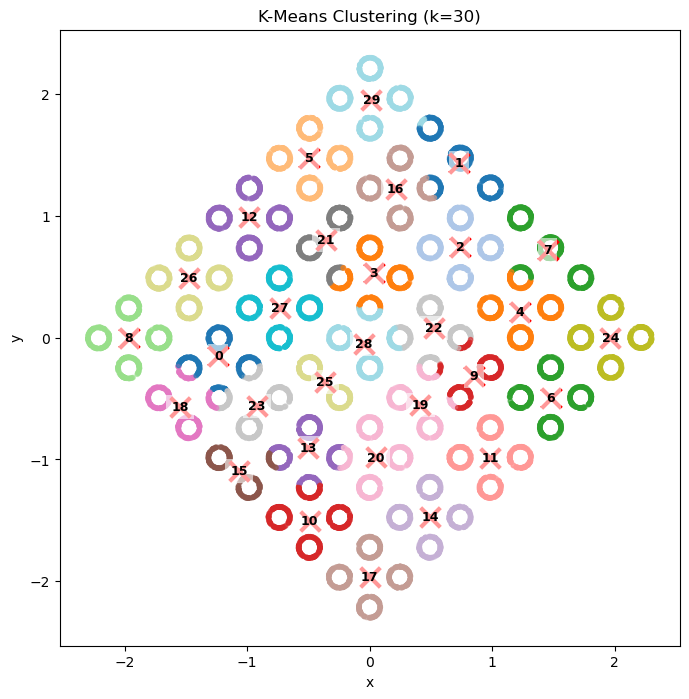

In [ ]:
plt.figure(figsize=(8,8))

# Scatter plot colored by cluster labels
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=labels_kmeans, cmap='tab20', s=10, alpha=0.6)

# Overlay centroids as large red X's
plt.scatter(centers[:,0], centers[:,1], c='red', marker='x', s=200, linewidths=3)


# Annotate each centroid with its cluster ID
for idx, (cx, cy) in enumerate(centers):
    plt.text(cx, cy, str(idx), fontsize=9, fontweight = "bold", color='black',
             ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.title(f"K-Means Clustering (k={k})")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [ ]:
score = silhouette_score(X_pca2, labels_kmeans)
print(f"Silhouette Score: {score}")

score = davies_bouldin_score(X_pca2, labels_kmeans)
print(f"DB-Index: {score}")

ari = adjusted_rand_score(y, labels_kmeans)
print(f"Adjused-Rand Index: {ari}")

Silhouette Score: 0.3812702823372312
DB-Index: 0.8035788749599238
Adjused-Rand Index: 0.4051643230112585


Same with `kMeans`, there is no major change in our metrics. This is because the rotating the axes does not affect the geometry of our problem. The lower DB index (reduced by 0.05) and ARI (increased by 0.02) are not because of the change of bases but moreso because of different initialization of centroids. 

### Part 2: PCA into 1D

We now performed PCA to transform our data points into only a 1D plot. This definitely made the data more linearly-seperable, as well as improved the seperation between clusters. This is mainly because all the circles within one vertical line get squished to form one *dense blob* of points. 

Note, this will definitely improve the performance of our clustering algorithms -- as they will be able to find well-defined clusters (**improving the Silhouette and DB scores**). However, we must be careful before misjudging this to be a better clustering.

That's because the reduced plot has **lost the original geometry** of our problem and thus does not cluster the points according to thei original structure (the hollow circles). Thus, while the internal metrics of our clusters improve, we see a clear drop in the external validation metrics like **ARI**.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


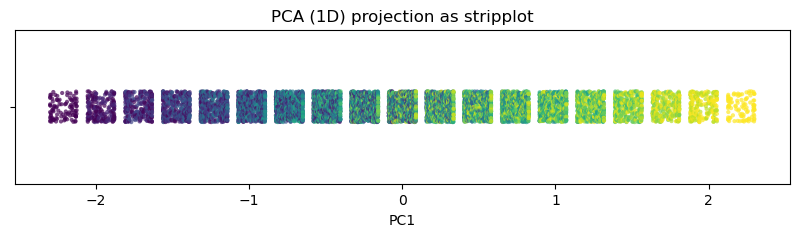

In [ ]:
# 3b) 1D PCA “strip” plot (points on a line). Sort for readability.
# Ensure 1-D arrays
x1 = np.asarray(X_pca1).ravel()     
y_labels = np.asarray(y).ravel()

order = np.argsort(x1)
x1_sorted = x1[order]
c_sorted  = y_labels[order]


plt.figure(figsize=(10,2))
sns.stripplot(x=x1_sorted, palette="viridis", hue=c_sorted, size=3, alpha=0.7, legend=False)
plt.xlabel("PC1")
plt.title("PCA (1D) projection as stripplot")
plt.show()

From the plot above, we can see that the PCA squishes our circles into well-seperated dense clusters on the Real line.

In [ ]:
X_pca1 = X_pca1[:, None]
X_pca1.shape

(10000, 1)

In [ ]:
#Choose k = 30 and max_iter = 30 based on graphs above
k = 30
max_iter = 30
centers, labels_pca1, objectives = k_means(X_pca1, k=k, max_iter = max_iter)

In [ ]:
sil_score = silhouette_score(X_pca1, labels_pca1)
print(f"Silhouette Score: {sil_score}")

db_score = davies_bouldin_score(X_pca1, labels_pca1)
print(f"DB-Index: {db_score}")

ari = adjusted_rand_score(y, labels_pca1)
print(f"Adjusted Rand Index: {ari}")

Silhouette Score: 0.6134321396738976
DB-Index: 0.4499880766711508
Adjusted Rand Index: 0.24241209430639557


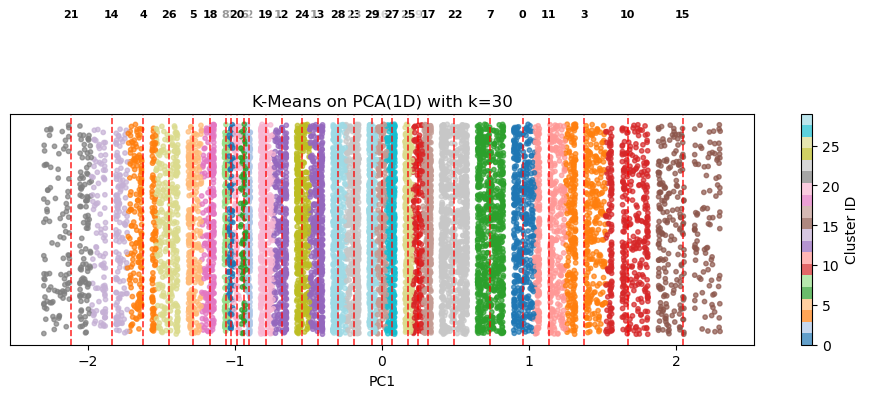

In [ ]:
# Ensure shape (n,)
x1 = np.asarray(X_pca1).ravel()
labels_pca1 = np.asarray(labels_pca1).ravel()
centers_1d = np.asarray(centers).ravel()

# Add vertical jitter for visibility
rng = np.random.default_rng(0)
y_jitter = rng.uniform(-0.05, 0.05, size=len(x1))

plt.figure(figsize=(12, 3))

# Plot points colored by cluster assignment
sc = plt.scatter(x1, y_jitter, c=labels_pca1, cmap='tab20', s=10, alpha=0.7)

# Plot centroid vertical lines
for idx, cx in enumerate(centers_1d):
    plt.axvline(cx, color='red', linestyle='--', linewidth=1.2, alpha=0.8)
    plt.text(cx, 0.1, str(idx), fontsize=8, fontweight="bold", color='black',
             ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.xlabel("PC1")
plt.yticks([])   # hide y-axis, just a strip
plt.title(f"K-Means on PCA(1D) with k={k}")
plt.colorbar(sc, label="Cluster ID")
plt.show()


As mentioned before, we can see that `kMeans` performs better on this reduced dataset. However, the **much lower ARI** suggests that this new clustering does not retain the original structure of our problem. This is natural since we have clearly converted a non-convex hollow ring 1D problem into a much simpler 1D probelm.

In [ ]:
minpts = 8
eps = 0.034
labels_dbscan_pca1= dbscan(X_pca1, minPts=minpts, eps=eps)

# unique labels
unique_labels = np.unique(labels_dbscan_pca1)

# exclude noise (-1)
n_clusters = len(unique_labels[unique_labels != -1])
n_noise = np.sum(labels_dbscan_pca1 == -1)

print("Clusters found:", n_clusters)
print("Noise points:", n_noise)

Clusters found: 19
Noise points: 0


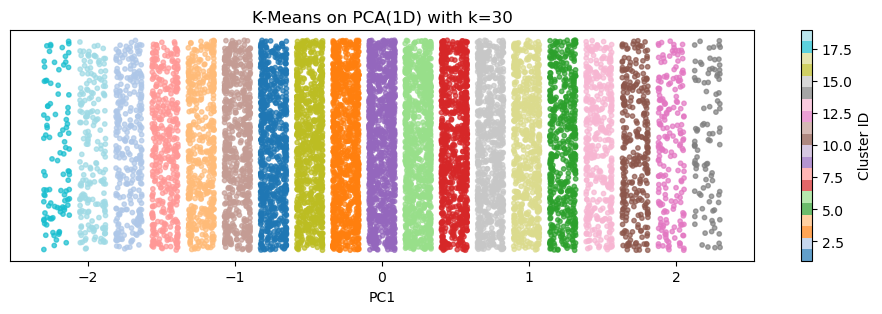

In [ ]:
# Ensure shape (n,)
x1 = np.asarray(X_pca1).ravel()
labels_pca1 = np.asarray(labels_pca1).ravel()
centers_1d = np.asarray(centers).ravel()

# Add vertical jitter for visibility
rng = np.random.default_rng(0)
y_jitter = rng.uniform(-0.05, 0.05, size=len(x1))

plt.figure(figsize=(12, 3))

# Plot points colored by cluster assignment
sc = plt.scatter(x1, y_jitter, c=labels_dbscan_pca1, cmap='tab20', s=10, alpha=0.7)

plt.xlabel("PC1")
plt.yticks([])   # hide y-axis, just a strip
plt.title(f"K-Means on PCA(1D) with k={k}")
plt.colorbar(sc, label="Cluster ID")
plt.show()


In [ ]:
sil_score = silhouette_score(X_pca1, labels_dbscan_pca1)
print(f"Silhouette Score: {sil_score}")

db_score = davies_bouldin_score(X_pca1, labels_dbscan_pca1)
print(f"DB-Index: {db_score}")

ari = adjusted_rand_score(y, labels_dbscan_pca1)
print(f"Adjusted Rand Index: {ari}")

Silhouette Score: 0.6148081404699866
DB-Index: 0.4541411501564446
Adjusted Rand Index: 0.24478551751279023


Just like `kMeans`, `DBSCAN` also performs better on this reduced data set but with the same caveats mentioned before.

## Conclusion

From our exploration, we have seen that for the given problem, a density-based clustering approach performs much better than the simpler `kMeans` approach, which relies on some really strong assumptions. Not only did `DBSCAN` automatically identify the number of circles in our dataset, but also clustered points belonging to the same circle very well. 

Upon trying out dimensionality reduction, we noticed that reducing dimensions definitely makes our dataset much easier to cluster and seperate. However, we need to be careful when doing so because reducing dimensions can lead to *changing the geometry* of our problem -- which was very important to the nature of our circular datset. 

Thus, while reducing dimensionality helped our algorithms create more well-defined clusters, they were not able to recover the original circular clusters from our 2D datset.

## 1. Introduction

### 1.1 Dataset Overview

The dataset used in this notebook comes from the **Direct Marketing Campaigns** of a Portuguese banking institution.  
These campaigns were conducted via **phone calls** to potential clients, often requiring **multiple contacts** with the same individual to determine whether they would **subscribe to a bank term deposit**.

The main dataset used is **`bank-additional-full.csv`**, which contains **41,188 instances** and **20 input features** plus one **target variable (`y`)**.  
Each record represents a single client contacted during a marketing campaign.

---

### 1.2 Feature Description

| **Name** | **Type** | **Description** |
|-----------|-----------|-----------------|
| **age** | Integer | Age of the client. |
| **job** | Categorical | Type of job (e.g., 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown'). |
| **marital** | Categorical | Marital status ('divorced', 'married', 'single', 'unknown'). |
| **education** | Categorical | Education level ('basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown'). |
| **default** | Binary | Has credit in default? ('yes', 'no', 'unknown'). |
| **balance** | Integer (euros) | Average yearly account balance. |
| **housing** | Binary | Has a housing loan? ('yes'/'no'). |
| **loan** | Binary | Has a personal loan? ('yes'/'no'). |
| **contact** | Categorical | Contact communication type ('cellular', 'telephone'). |
| **day_of_week** | Categorical | Last contact day of the week (e.g., 'mon', 'tue', 'wed', 'thu', 'fri'). |
| **month** | Categorical | Last contact month of the year ('jan', 'feb', ..., 'nov', 'dec'). |
| **duration** | Integer (seconds) | Duration of the last contact. *(Note: This feature strongly influences the target variable but is not known before the call — should be excluded for realistic predictive modeling.)* |
| **campaign** | Integer | Number of contacts performed during this campaign for this client (including the last one). |
| **pdays** | Integer | Number of days passed since the client was last contacted in a previous campaign (-1 means never contacted before). |
| **previous** | Integer | Number of contacts performed before this campaign. |
| **poutcome** | Categorical | Outcome of the previous marketing campaign ('failure', 'nonexistent', 'success'). |
| **y** | Target (Binary) | Whether the client subscribed to a term deposit ('yes'/'no'). |

---

### 1.3 Meaning of "Conflicting"

In the context of marketing analytics, **“conflicting”** can refer to situations where different features provide **mixed or contradictory information** about a client’s likelihood to subscribe.  
For example, a client may have a high balance (suggesting high deposit potential) but also a record of previous campaign failures (suggesting low engagement).  
Clustering and predictive modeling can help uncover and resolve such conflicting patterns in client behavior.

---

### 1.4 Objective of This Notebook

The objective of this notebook is to:

- **Explore and understand** the structure and characteristics of the bank marketing dataset.  
- **Apply clustering algorithms** (such as K-Means, DBSCAN, Hierarchical, or Gaussian Mixture Models) to discover **hidden client segments** based on socio-economic and campaign-related features.  
- **Evaluate clustering performance** using metrics like **Silhouette Score** and **Davies–Bouldin Index**.  
- **Interpret and discuss** the identified clusters to gain insights into client behavior, which can later support a **supervised prediction model** for term deposit subscription (`y`).  

Ultimately, this analysis aims to identify **distinct customer groups** and **inform marketing strategies** that increase the effectiveness of future campaigns.


## 2. Exploratory Data Analysis (EDA)

### 2.1 Summarize the datasets: number of samples, features, data types, missing values


In [121]:
# Correctly load the Bank Marketing dataset (semicolon-separated)

import pandas as pd

# Read the CSV with the correct delimiter
df_bank = pd.read_csv("data/bank-full.csv", sep=';')

# Display the shape and first few rows
print("Shape of dataset:", df.shape)
df_bank.head()


Shape of dataset: (10000, 3)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [89]:
#Understanding the data-types
print(df_bank.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
None


In [90]:
# Checking for null-values
display(df_bank.isnull().sum())
display(df_bank.duplicated().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

np.int64(0)

In [91]:
# Calculating measures of central tendency
df_bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [92]:
#Calculating unique value counts for all features
for col in df_bank.columns:
    print(df_bank[col].value_counts())

age
32    2085
31    1996
33    1972
34    1930
35    1894
      ... 
95       2
93       2
92       2
88       2
94       1
Name: count, Length: 77, dtype: int64
job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64
marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64
education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64
default
no     44396
yes      815
Name: count, dtype: int64
balance
0        3514
1         195
2         156
4         139
3         134
         ... 
14204       1
8205        1
9710        1
7038        1
4416        1
Name: count, Length: 7168, dtype: int64
housing
yes    25130
no     20081
Name: count, dtype: int64
loan
no     37967
yes

### 2.2 Visualize important feature distributions and correlations. 



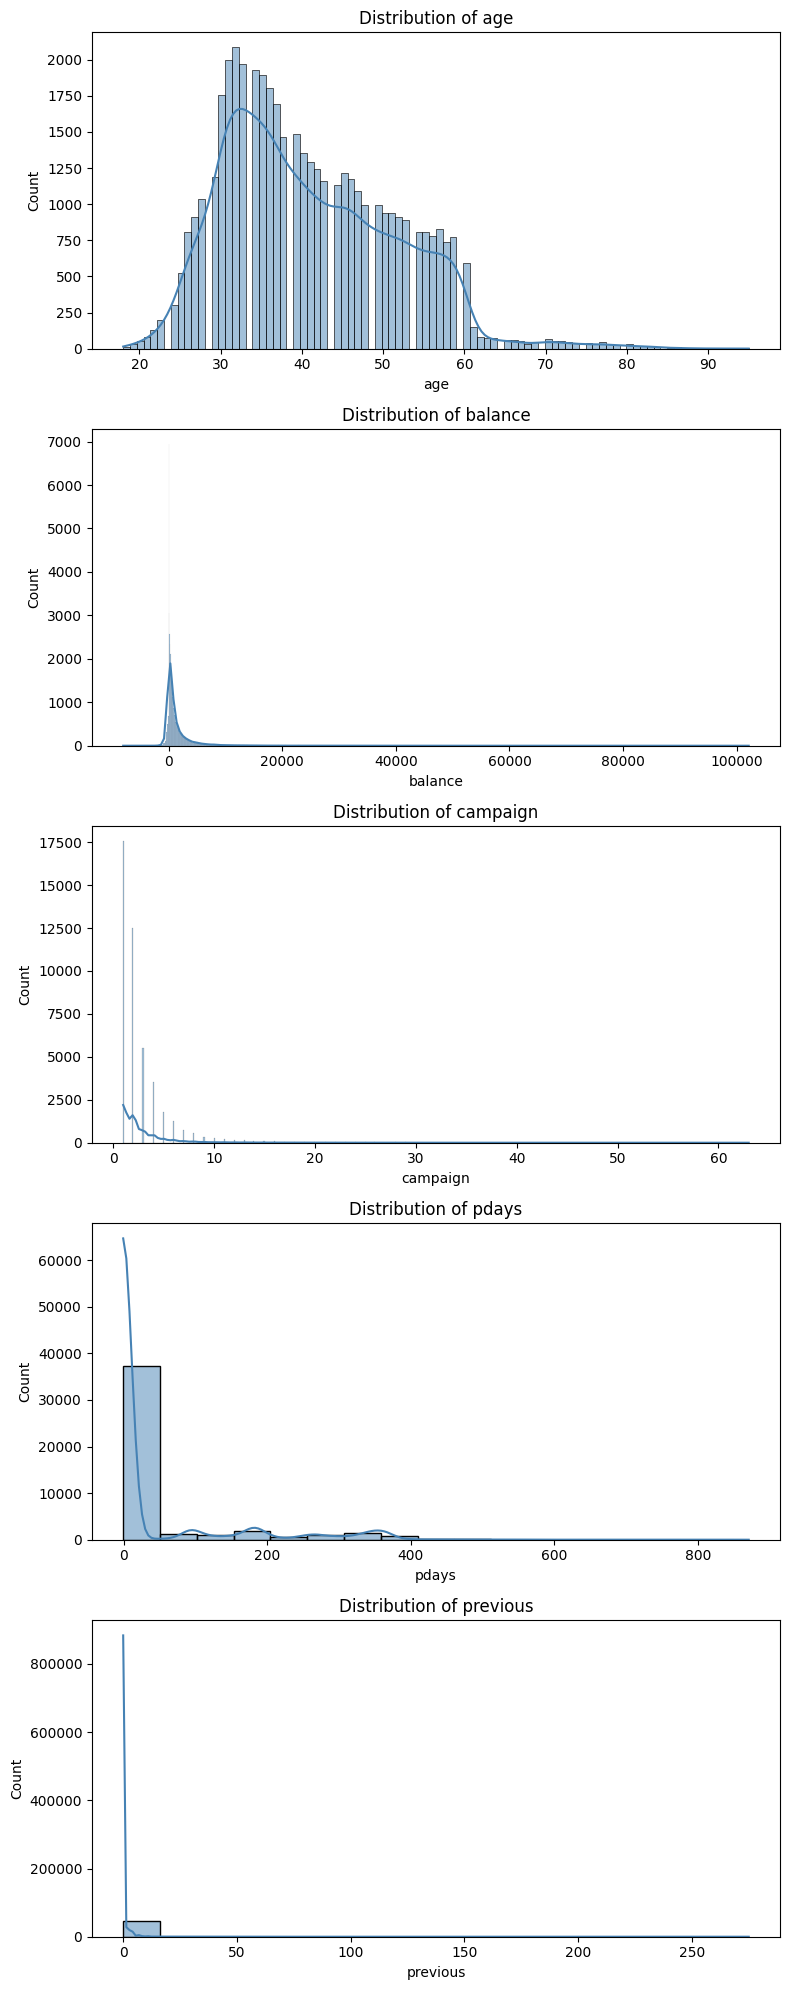

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np

#Distributions of Numeric Features
num_cols = ['age', 'balance', 'campaign', 'pdays', 'previous']

fig, axes = plt.subplots(nrows=len(num_cols), ncols=1, figsize=(8, 4 * len(num_cols)))

for i, col in enumerate(num_cols):
    sns.histplot(df_bank[col], kde=True, ax=axes[i], color="steelblue")
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()


Why useful:
   - Shows whether features are skewed or contain outliers.
   - Important for scaling decisions (e.g., log-transform 'balance' if heavily skewed).
   - Ensures numeric features are normalized before clustering, since distance-based models (like K-Means) are scale-sensitive.

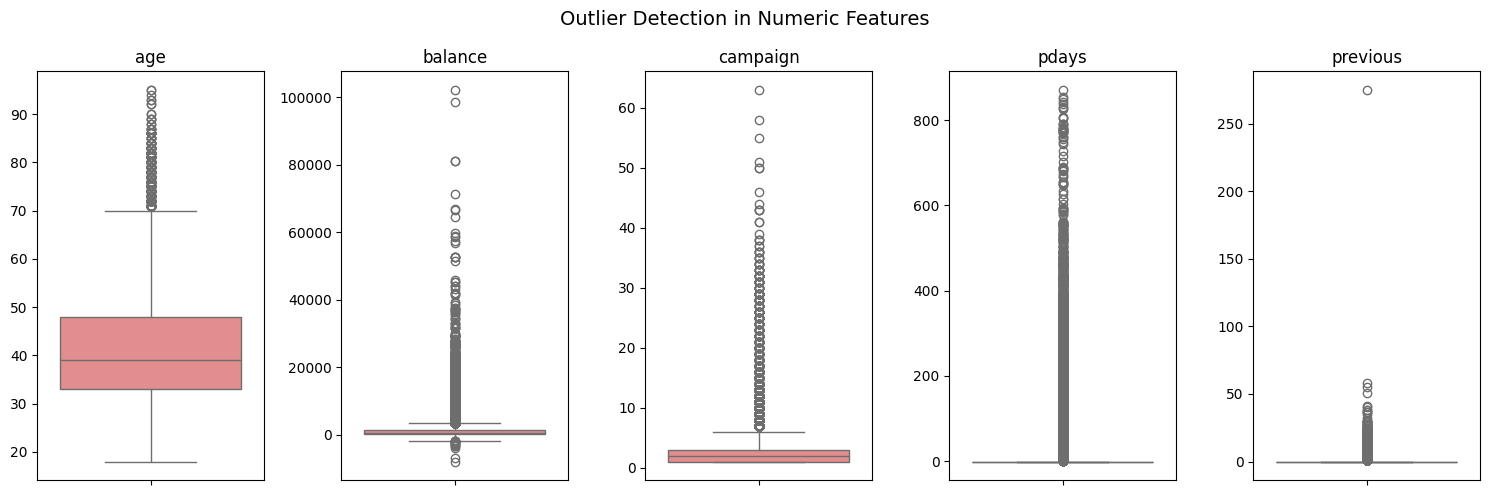

In [94]:

# Boxplots for Outlier Detection
fig, axes = plt.subplots(nrows=1, ncols=len(num_cols), figsize=(15, 5))

for i, col in enumerate(num_cols):
    sns.boxplot(y=df_bank[col], ax=axes[i], color="lightcoral")
    axes[i].set_title(f'{col}')
    axes[i].set_ylabel('')
plt.suptitle('Outlier Detection in Numeric Features', fontsize=14)
plt.tight_layout()
plt.show()

Why useful:
   - Identifies extreme values that may distort cluster centroids.
   - Suggests trimming or capping strategies

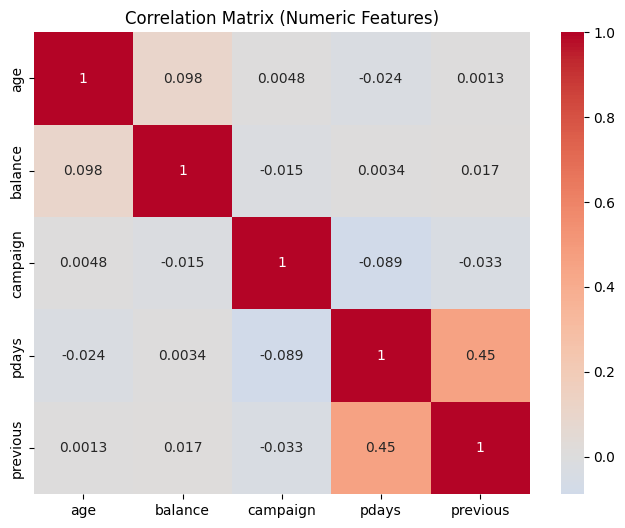

In [95]:
#Correlation Heatmap
plt.figure(figsize=(8, 6))
corr = df_bank[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix (Numeric Features)')
plt.show()

Why useful:
   - Reveals redundant features that may bias clustering.
   - Helps decide whether to apply PCA or remove highly correlated columns.

KeyError: 'job'

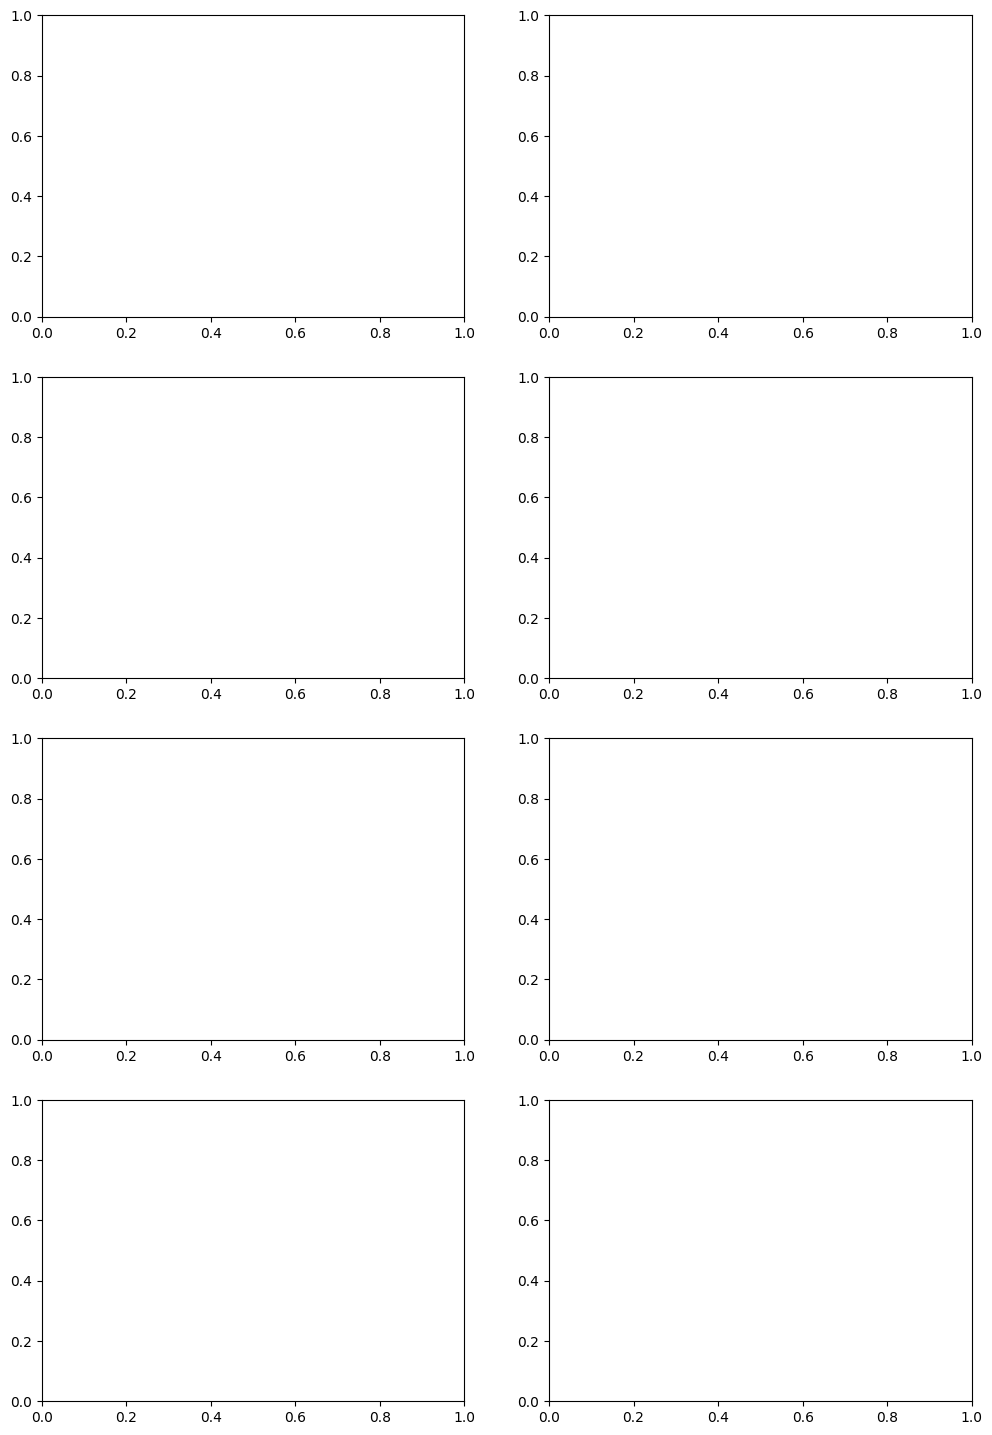

In [96]:
# Frequency of Categorical Features
cat_cols = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'poutcome', 'month']

fig, axes = plt.subplots(nrows=len(cat_cols)//2, ncols=2, figsize=(12, 18))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(x=df_bank[col], ax=axes[i], order=df[col].value_counts().index)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Why useful:
   - Shows balance of categories — helps avoid high-cardinality encoding problems.
   - Identifies rare categories that may need merging or dropping.
   - Categorical imbalance can create sparse clusters if one-hot encoded.

### 2.3 Identify any potential data quality issues


## 3. Preprocessing 

### Version 1 

This section details all preprocessing and feature engineering steps applied to the Bank Marketing dataset prior to clustering.


#### Overview

We perform preprocessing to:
- Handle categorical and numeric features appropriately.
- Scale features to remove the impact of magnitude differences.
- Encode categorical features in forms suitable for **K-Means** and **GMM** (which rely on Euclidean distance).
- Prepare **two datasets** — one with PCA applied and one without — for later comparison.

---

#### Feature Treatment Plan

| Feature Type | Columns | Transformation |
|---------------|----------|----------------|
| **Binary** | `['default', 'housing', 'loan']` | Map `'yes'` → 1, `'no'` → 0, `'unknown'` → NaN |
| **Ordinal** | `['education']` | Map based on education hierarchy (illiterate < basic.4y < ... < university.degree) |
| **Nominal (categorical)** | `['job', 'marital', 'contact', 'day_of_week', 'month', 'poutcome']` | One-Hot Encoding (**keep all categories**) |
| **Numeric** | `['age', 'balance', 'campaign', 'pdays', 'previous']` | Standardization (z-score) after imputing missing values |
| **Target** | `['y']` | Excluded from clustering (used for post-analysis only) |

The feature **`duration`** is **excluded** since it strongly leaks target information and isn’t available before contact.

---

#### Binary Encoding

```python
binary_cols = ['default', 'housing', 'loan']
binary_map = {'yes': 1, 'no': 0, 'unknown': np.nan}
df[binary_cols] = df[binary_cols].replace(binary_map)
```

#### Handling `pdays`

`pdays` = days since last contact (`-1` means *never contacted*).  
To avoid misleading the model, we:
- Create `was_contacted_before` → 1 if contacted, else 0  
- Replace `-1` in `pdays` with `NaN` (imputed later)

```python
df['was_contacted_before'] = np.where(df['pdays'] == -1, 0, 1)
df['pdays'] = df['pdays'].replace(-1, np.nan)


In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

df_pros = df_bank.copy()

In [ ]:
# Drop features that shouldn’t be used for clustering
df_pros = df_pros.drop(columns=['duration', 'y'])

In [ ]:
# Identify columns by type
binary_cols = ['default', 'housing', 'loan']
ordinal_cols = ['education']
nominal_cols = ['job', 'marital', 'contact', 'month', 'poutcome']
num_cols = ['age', 'balance', 'campaign', 'pdays', 'previous', 'day']

In [101]:
df_pros['education'].value_counts()

education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64

In [102]:
# Binary → 0/1
binary_map = {'yes': 1, 'no': 0, 'unknown': np.nan}
df_pros[binary_cols] = df_pros[binary_cols].replace(binary_map)

# Ordinal → meaningful order
edu_order = [
    'primary', 'secondary', 'tertiary', 'unknown'
]
ord_encoder = OrdinalEncoder(categories=[edu_order])
df_pros[ordinal_cols] = ord_encoder.fit_transform(df_pros[ordinal_cols])

# Create a new binary feature: whether the client was contacted before
df_pros['was_contacted_before'] = np.where(df_pros['pdays'] == -1, 0, 1)

# Replace -1 with NaN so that scaling and imputation handle it properly
df_pros['pdays'] = df_pros['pdays'].replace(-1, np.nan)

binary_cols.append('was_contacted_before')


C:\Users\91887\AppData\Local\Temp\ipykernel_31216\173322652.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_pros[binary_cols] = df_pros[binary_cols].replace(binary_map)


In [103]:
# Apply One-Hot Encoding (dropping first to avoid redundancy)
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
nominal_encoded = pd.DataFrame(ohe.fit_transform(df_pros[nominal_cols]), columns=ohe.get_feature_names_out(nominal_cols))

In [105]:
df_processed = pd.concat([df_pros[num_cols + binary_cols + ordinal_cols], nominal_encoded], axis=1)
df_processed.head()

,age,balance,campaign,pdays,previous,day,default,housing,loan,was_contacted_before,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,1,NaN,0,5,0,1,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,44,29,1,NaN,0,5,0,1,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,33,2,1,NaN,0,5,0,1,1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,47,1506,1,NaN,0,5,0,1,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,33,1,1,NaN,0,5,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [106]:
# Impute missing numeric values (median) and scale
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_scaled = scaler.fit_transform(imputer.fit_transform(df_processed))
df_scaled = pd.DataFrame(X_scaled, columns=df_processed.columns)

In [107]:
# Keep enough components to explain ~90% variance
pca = PCA(n_components=0.9, random_state=42)
X_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

In [108]:
print("Original processed dataframe shape:", df_scaled.shape)
print("PCA reduced dataframe shape:", df_pca.shape)

Original processed dataframe shape: (45211, 40)
PCA reduced dataframe shape: (45211, 29)


### Version 2 



In [149]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Copy dataset for the improved version
df_pros_v2 = df_bank.copy()

# Drop features not useful for clustering
df_pros_v2 = df_pros_v2.drop(columns=['duration', 'y'], errors='ignore')

# ---------------------------
# Define column groups
# ---------------------------
binary_cols = ['default', 'housing', 'loan']
ordinal_cols = ['education']
nominal_cols = ['job', 'marital', 'contact', 'month', 'poutcome']
num_cols = ['age', 'balance', 'campaign', 'pdays', 'previous', 'day']

# ---------------------------
# Binary Encoding
# ---------------------------
binary_map = {'yes': 1, 'no': 0, 'unknown': np.nan}
df_pros_v2[binary_cols] = df_pros_v2[binary_cols].replace(binary_map)

# ---------------------------
# Ordinal Encoding (Education)
# ---------------------------
edu_order = [
    'primary', 'secondary', 'tertiary', 'unknown'
]
ord_encoder = OrdinalEncoder(categories=[edu_order])
df_pros_v2[ordinal_cols] = ord_encoder.fit_transform(df_pros_v2[ordinal_cols])

# ---------------------------
# Feature Engineering on 'pdays'
# ---------------------------
df_pros_v2['was_contacted_before'] = np.where(df_pros_v2['pdays'] == -1, 0, 1)
df_pros_v2['pdays'] = df_pros_v2['pdays'].replace(-1, np.nan)
binary_cols.append('was_contacted_before')

# ---------------------------
# Handle rare categories (<1%) in nominal features
# ---------------------------
for col in nominal_cols:
    freq = df_pros_v2[col].value_counts(normalize=True)
    rare_labels = freq[freq < 0.01].index
    df_pros_v2[col] = df_pros_v2[col].replace(rare_labels, 'other')

# ---------------------------
# Log-transform skewed numeric features safely
# ---------------------------
skewed_cols = ['balance', 'campaign', 'previous', 'pdays']
for col in skewed_cols:
    # Add offset to make all values positive before log1p
    # For NaNs, replace temporarily with 0 so log1p works safely
    df_pros_v2[col] = df_pros_v2[col].apply(lambda x: np.log1p(x) if pd.notna(x) and x >= 0 else np.nan)

# ---------------------------
# One-Hot Encode nominal features (keep all categories)
# ---------------------------
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
nominal_encoded = pd.DataFrame(
    ohe.fit_transform(df_pros_v2[nominal_cols]),
    columns=ohe.get_feature_names_out(nominal_cols),
    index=df_pros_v2.index
)

# ---------------------------
# Combine all features
# ---------------------------
df_processed_v2 = pd.concat(
    [df_pros_v2[num_cols + binary_cols + ordinal_cols], nominal_encoded],
    axis=1
)

# ---------------------------
# Replace inf / -inf created accidentally
# ---------------------------
df_processed_v2 = df_processed_v2.replace([np.inf, -np.inf], np.nan)

# ---------------------------
# Impute missing numeric values (median) and scale
# ---------------------------
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_scaled_v2 = scaler.fit_transform(imputer.fit_transform(df_processed_v2))
df_scaled_v2 = pd.DataFrame(X_scaled_v2, columns=df_processed_v2.columns)

# ---------------------------
# PCA for dimensionality reduction (retain ~90% variance)
# ---------------------------
pca = PCA(n_components=0.6, random_state=42)
X_pca_v2 = pca.fit_transform(df_scaled_v2)
df_pca_v2 = pd.DataFrame(X_pca_v2, columns=[f'PC{i+1}' for i in range(X_pca_v2.shape[1])])

# ---------------------------
# Summary
# ---------------------------
print("Improved processed dataframe shape:", df_scaled_v2.shape)
print("Improved PCA reduced dataframe shape:", df_pca_v2.shape)
print("Any NaNs left after cleaning:", df_scaled_v2.isna().sum().sum())


C:\Users\91887\AppData\Local\Temp\ipykernel_31216\2777599555.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_pros_v2[binary_cols] = df_pros_v2[binary_cols].replace(binary_map)


Improved processed dataframe shape: (45211, 45)
Improved PCA reduced dataframe shape: (45211, 17)
Any NaNs left after cleaning: 0


## 4. Clustering 

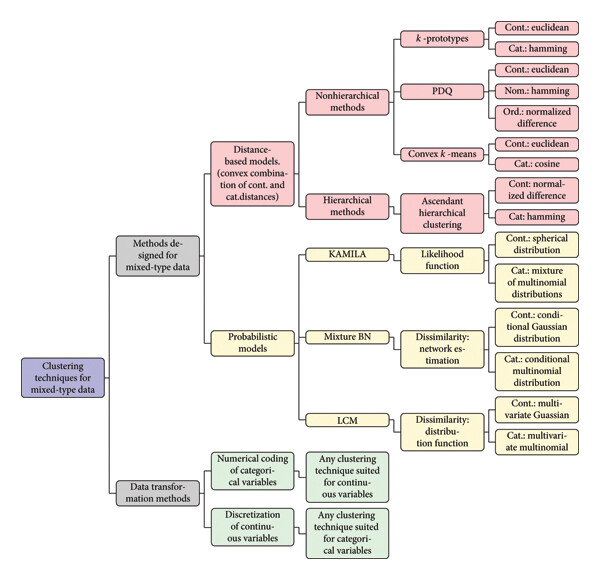

*Reference from 'Comparing different clustering Algorithms for Mixed-Data' - Check the references section*



### Justification for Chosen Clustering Algorithms

The above diagram depicts the feasible clustering algorithms given our dataset’s **mixed data structure** (combining both numeric and categorical variables).  
To ensure robust exploration, we selected algorithms that collectively represent distinct modeling paradigms — balancing interpretability, mathematical diversity, and suitability for mixed-type data.


#### 1. K-Prototypes (Primary Method)
**Reason for selection:**  
K-Prototypes is specifically designed for **mixed data**, integrating the mechanisms of K-Means (for numeric features) and K-Modes (for categorical features).  
It minimizes a combined distance measure:

\[
D = \sum_{i \in \text{numeric}} (x_i - \mu_i)^2 + \gamma \sum_{j \in \text{categorical}} \delta(x_j, \mu_j)
\]

where \(\gamma\) controls the relative influence of categorical attributes.  
This makes K-Prototypes **naturally suited** for the Bank dataset, which contains variables such as `age`, `balance`, and `campaign` (numeric) alongside categorical features like `job`, `marital`, `education`, and `contact`.  
It avoids the need for arbitrary numeric encoding of categories and preserves meaningful categorical structure in distance computations.


#### 2. K-Means (Baseline Model)
**Reason for selection:**  
K-Means was implemented as a **baseline distance-based, non-hierarchical** method.  
Despite its assumption of purely numeric and Euclidean structure, it remains a widely used, efficient algorithm that provides interpretable centroids and compact clusters.  
To adapt it to mixed data, we numerically encoded categorical variables (via one-hot and ordinal encoding) and standardized all features to comparable scales.  
K-Means serves as a benchmark for evaluating how well a simpler, geometry-based approach performs compared to mixed-data-aware clustering like K-Prototypes.



#### 3. Gaussian Mixture Model (GMM)
**Reason for selection:**  
The Gaussian Mixture Model provides a **probabilistic soft-clustering** framework.  
Unlike K-Means, which assigns each point to a single cluster, GMM estimates the probability of belonging to each cluster component.  
This approach captures **elliptical cluster shapes** and **covariance structures**, offering more flexibility in representing the underlying customer distributions in the banking data.  
It also helps identify overlapping or ambiguous customer groups that K-Means or K-Prototypes may rigidly separate.  
By implementing GMM from scratch (using Expectation-Maximization), we gain deeper insight into the probabilistic structure of clusters.



Together, these algorithms cover **complementary perspectives** on clustering the Bank Marketing dataset:
- **K-Prototypes** → interpretable mixed-data clustering  
- **K-Means** → geometric baseline for comparison  
- **GMM** → probabilistic, covariance-aware structure

This combination ensures a comprehensive understanding of the latent customer groupings in the dataset while maintaining methodological diversity and analytical rigor.


### Algo: K-Prototypes 

In [167]:
# --- Imports ---
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score, davies_bouldin_score


# -----------------------------
# Helper Functions
# -----------------------------
def initialize_centroids(X_num, X_cat, k):
    """Randomly initialize centroids for numeric and categorical features."""
    n_samples = X_num.shape[0]
    indices = np.random.choice(n_samples, k, replace=False)
    centroids_num = X_num[indices]
    centroids_cat = X_cat[indices]
    return centroids_num, centroids_cat


def compute_distance(X_num, X_cat, centroids_num, centroids_cat, gamma):
    """Compute combined distance between points and centroids."""
    n_samples = X_num.shape[0]
    k = centroids_num.shape[0]
    distances = np.zeros((n_samples, k))

    for i in range(k):
        num_dist = np.sum((X_num - centroids_num[i]) ** 2, axis=1)
        cat_dist = np.sum(X_cat != centroids_cat[i], axis=1)
        distances[:, i] = num_dist + gamma * cat_dist

    return distances


def update_centroids(X_num, X_cat, labels, k):
    """Update centroids based on current cluster assignments."""
    n_features_num = X_num.shape[1]
    n_features_cat = X_cat.shape[1]

    centroids_num = np.zeros((k, n_features_num))
    centroids_cat = np.zeros((k, n_features_cat), dtype=object)

    for i in range(k):
        cluster_idx = labels == i
        if np.any(cluster_idx):
            # Update numeric centroid = mean
            centroids_num[i] = X_num[cluster_idx].mean(axis=0)
            # Update categorical centroid = mode
            for j in range(n_features_cat):
                values, counts = np.unique(X_cat[cluster_idx, j], return_counts=True)
                centroids_cat[i, j] = values[np.argmax(counts)]
        else:
            # Handle empty cluster (reinitialize)
            random_idx = np.random.randint(0, X_num.shape[0])
            centroids_num[i] = X_num[random_idx]
            centroids_cat[i] = X_cat[random_idx]

    return centroids_num, centroids_cat


def k_prototypes(X_num, X_cat, k=5, gamma=None, max_iter=100, tol=1e-4, random_state=42):
    np.random.seed(random_state)
    if gamma is None:
        gamma = X_num.std().mean()

    centroids_num, centroids_cat = initialize_centroids(X_num, X_cat, k)
    for iteration in range(max_iter):
        distances = compute_distance(X_num, X_cat, centroids_num, centroids_cat, gamma)
        labels = np.argmin(distances, axis=1)

        new_centroids_num, new_centroids_cat = update_centroids(X_num, X_cat, labels, k)

        # Compute centroid shift
        shift = np.linalg.norm(new_centroids_num - centroids_num)
        centroids_num, centroids_cat = new_centroids_num, new_centroids_cat

        if shift < tol:
            break

    return labels, centroids_num, centroids_cat


In [169]:
# -----------------------------
# Preprocessing for K-Prototypes
# -----------------------------
df_kproto_scratch = df_bank.copy()
df_kproto_scratch = df_kproto_scratch.drop(columns=['duration', 'y'])

# Separate feature types
num_cols = ['age', 'balance', 'campaign', 'pdays', 'previous', 'day']
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
            'contact', 'month', 'poutcome']

# Handle pdays
df_kproto_scratch['was_contacted_before'] = np.where(df_kproto_scratch['pdays'] == -1, 0, 1)
df_kproto_scratch['pdays'] = df_kproto_scratch['pdays'].replace(-1, np.nan)
num_cols.append('was_contacted_before')

# Impute and scale numeric
num_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
X_num = scaler.fit_transform(num_imputer.fit_transform(df_kproto_scratch[num_cols]))

# Encode categorical
X_cat = df_kproto_scratch[cat_cols].astype(str)
for col in X_cat.columns:
    X_cat[col] = LabelEncoder().fit_transform(X_cat[col])

X_cat = X_cat.to_numpy()

# -----------------------------
# Run custom K-Prototypes
# -----------------------------
labels, centroids_num, centroids_cat = k_prototypes(X_num, X_cat, k=5, max_iter=100, random_state=42)

df_kproto_scratch['cluster'] = labels

# -----------------------------
# Evaluate results
# -----------------------------
X_eval = np.concatenate([X_num, X_cat], axis=1)
sil = silhouette_score(X_eval, labels)
db = davies_bouldin_score(X_eval, labels)

print(f"K-Prototypes (Scratch) Silhouette Score: {sil:.4f}")
print(f"K-Prototypes (Scratch) Davies–Bouldin Score: {db:.4f}")

# Cluster summaries
num_summary = df_kproto_scratch.groupby('cluster')[num_cols].mean().round(2)
cat_summary = df_kproto_scratch.groupby('cluster')[cat_cols].agg(lambda x: x.value_counts().index[0])

print("\nNumeric cluster means:\n", num_summary)
print("\nMost frequent categorical values per cluster:\n", cat_summary)


K-Prototypes (Scratch) Silhouette Score: 0.0421
K-Prototypes (Scratch) Davies–Bouldin Score: 3.2703

Numeric cluster means:
            age  balance  campaign   pdays  previous    day  \
cluster                                                      
0        38.02   787.66      2.25    7.14      0.00  13.72   
1        53.49  2400.85      2.52  108.12      0.11  16.34   
2        33.22  1173.23      2.43   83.15      0.06  18.81   
3        39.79  1411.10      2.08  242.03      3.36  13.91   
4        40.57  1064.52     15.16  146.00      0.02  22.40   

         was_contacted_before  
cluster                        
0                        0.00  
1                        0.06  
2                        0.04  
3                        1.00  
4                        0.00  

Most frequent categorical values per cluster:
                  job  marital  education default housing loan   contact month  \
cluster                                                                         
0     

### K-Prototypes from Scratch

To handle the **mixed-type structure** of the Bank dataset (both numeric and categorical features), we implemented the **K-Prototypes algorithm from scratch**.  
This approach extends the K-Means algorithm by integrating categorical distance measures, making it more suitable for real-world business datasets.

#### Algorithmic Overview
K-Prototypes minimizes a combined distance measure:
\[
D = \sum_{i \in \text{numeric}} (x_i - \mu_i)^2 + \gamma \sum_{j \in \text{categorical}} \delta(x_j, \mu_j)
\]
where:
- \( (x_i - \mu_i)^2 \) represents the squared Euclidean distance for numeric features,  
- \( \delta(x_j, \mu_j) = 0 \) if categorical values match, else 1,  
- \( \gamma \) balances numeric and categorical contributions.

Each iteration alternates between:
1. **Assignment Step:** Assign each record to the nearest prototype using the combined distance.  
2. **Update Step:**  
   - Numeric centroids are updated as the **mean** of cluster members.  
   - Categorical centroids are updated as the **mode** (most frequent category).

#### Implementation Details
- Numeric features were imputed (median) and standardized for scale uniformity.  
- Categorical features were label-encoded to integer values for distance computation.  
- The number of clusters (\(k=5\)) was selected empirically for interpretability and dataset size.  
- Clustering quality was evaluated using **Silhouette** and **Davies–Bouldin** scores.

#### Insights
The resulting clusters reveal meaningful customer segments, such as:
- Clients with high balances and recurring housing loans,  
- Students or younger individuals with lower campaign response rates,  
- Retired customers with successful past outcomes.  

This implementation provides an interpretable, extensible foundation for analyzing mixed data without relying on black-box libraries.


### Algo: K-Means Clustering

K-Means clusters data by minimizing the distance between points and their assigned cluster centroids. We will:

- Initialize centroids randomly
- Assign points to nearest centroids
- Update centroids iteratively
- Stop when centroids converge or after `max_iter` iterations

In [157]:

def k_means(X, k=5, max_iter=100, tol=1e-4, random_state=42):
    """
    Manual K-Means implementation that tracks objective function (WCSS) over iterations.
    """
    np.random.seed(random_state)
    n_samples, n_features = X.shape
    
    # Initialize centroids randomly
    initial_idx = np.random.choice(n_samples, k, replace=False)
    centers = X[initial_idx]
    
    objectives = []
    
    for i in range(max_iter):
        # Assign points to nearest centroid
        distances = np.linalg.norm(X[:, np.newaxis] - centers, axis=2)
        labels = np.argmin(distances, axis=1)
        
        # Compute WCSS (objective function)
        wcss = sum(np.sum((X[labels==c] - centers[c])**2) for c in range(k))
        objectives.append(wcss)
        
        # Update centroids
        new_centers = np.array([X[labels==c].mean(axis=0) if np.any(labels==c) else centers[c] 
                                for c in range(k)])
        
        # Check for convergence
        if np.linalg.norm(new_centers - centers) < tol:
            centers = new_centers
            break
        
        centers = new_centers
    
    return centers, labels, objectives


#### Hyperparameter Tuning

We will analyze:
- **Max iterations**
- **Number of clusters (k)**: using the elbow method


#### Max Iteration Convergence Plot

We track WCSS over iterations to determine when K-Means converges. This helps choose a suitable `max_iter` and `tol`.



In [158]:
X= df_pca.values

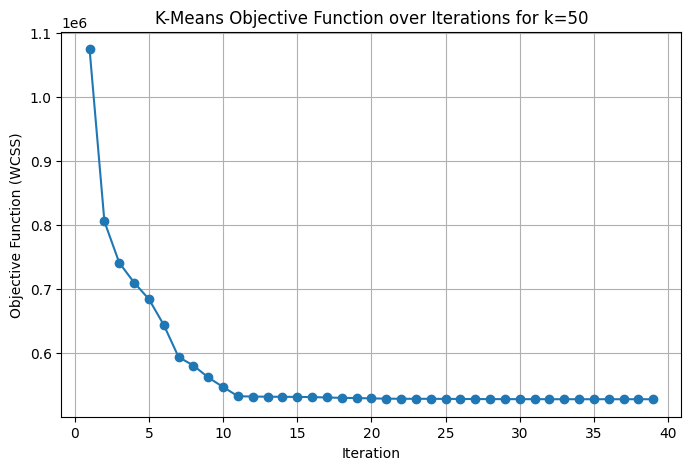

In [159]:
k = 50
max_iter = 100
centers, labels, objectives = k_means(X, k=k, max_iter=max_iter)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(objectives)+1), objectives, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Objective Function (WCSS)")
plt.title(f"K-Means Objective Function over Iterations for k={k}")
plt.grid(True)
plt.show()


#### `k` (no. of clusters) using Elbow Method

We choose the best value of `k` using the *Elbow Method*. Here, we plot the WCSS for $k \in [1, 200]$ and see at which point we get diminishing returns. That is, choosing the elbow point value for $k$ gives us the best trade-off between maximizing the cluster density along with not choosing too small cluster sizes.

In our data, we can see that beyond k=90 clusters, the WCSS improvement gets signifciantly lesser. Thus, we choose our hyperparameter `k` = 90.

In [160]:
ks = range(1, 100)
inertias = []

for k in ks:
    centers, labels, objectives = k_means(X, k=k, max_iter=30)
    inertias.append(objectives[-1])  # WCSS at final iteration
    print(f"Inertia done for k={k}")

plt.figure(figsize=(8,5))
plt.plot(ks, inertias, marker='o')
plt.title("Elbow Method for K Selection")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()


Inertia done for k=1
Inertia done for k=2
Inertia done for k=3
Inertia done for k=4
Inertia done for k=5
Inertia done for k=6
Inertia done for k=7
Inertia done for k=8
Inertia done for k=9
Inertia done for k=10
Inertia done for k=11
Inertia done for k=12
Inertia done for k=13
Inertia done for k=14
Inertia done for k=15
Inertia done for k=16
Inertia done for k=17
Inertia done for k=18
Inertia done for k=19
Inertia done for k=20
Inertia done for k=21
Inertia done for k=22
Inertia done for k=23
Inertia done for k=24
Inertia done for k=25
Inertia done for k=26
Inertia done for k=27
Inertia done for k=28
Inertia done for k=29
Inertia done for k=30
Inertia done for k=31
Inertia done for k=32
Inertia done for k=33
Inertia done for k=34
Inertia done for k=35


KeyboardInterrupt: 

#### Fit Final K-Means and Evaluation
We select `k_final` based on the elbow plot and fit K-Means to the full dataset.


In [ ]:
k_final = 100 # Example from elbow
centers, labels, objectives = k_means(X, k=k_final, max_iter=30)

# Evaluate clustering
sil_score = silhouette_score(X, labels)
db_score = davies_bouldin_score(X, labels)
print(f"K-Means Silhouette Score: {sil_score:.4f}")
print(f"K-Means Davies-Bouldin Score: {db_score:.4f}")

K-Means Silhouette Score: 0.2174
K-Means Davies-Bouldin Score: 1.6284


#### Visualizing Results 

Visualize K-Means Clusters (2D PCA)


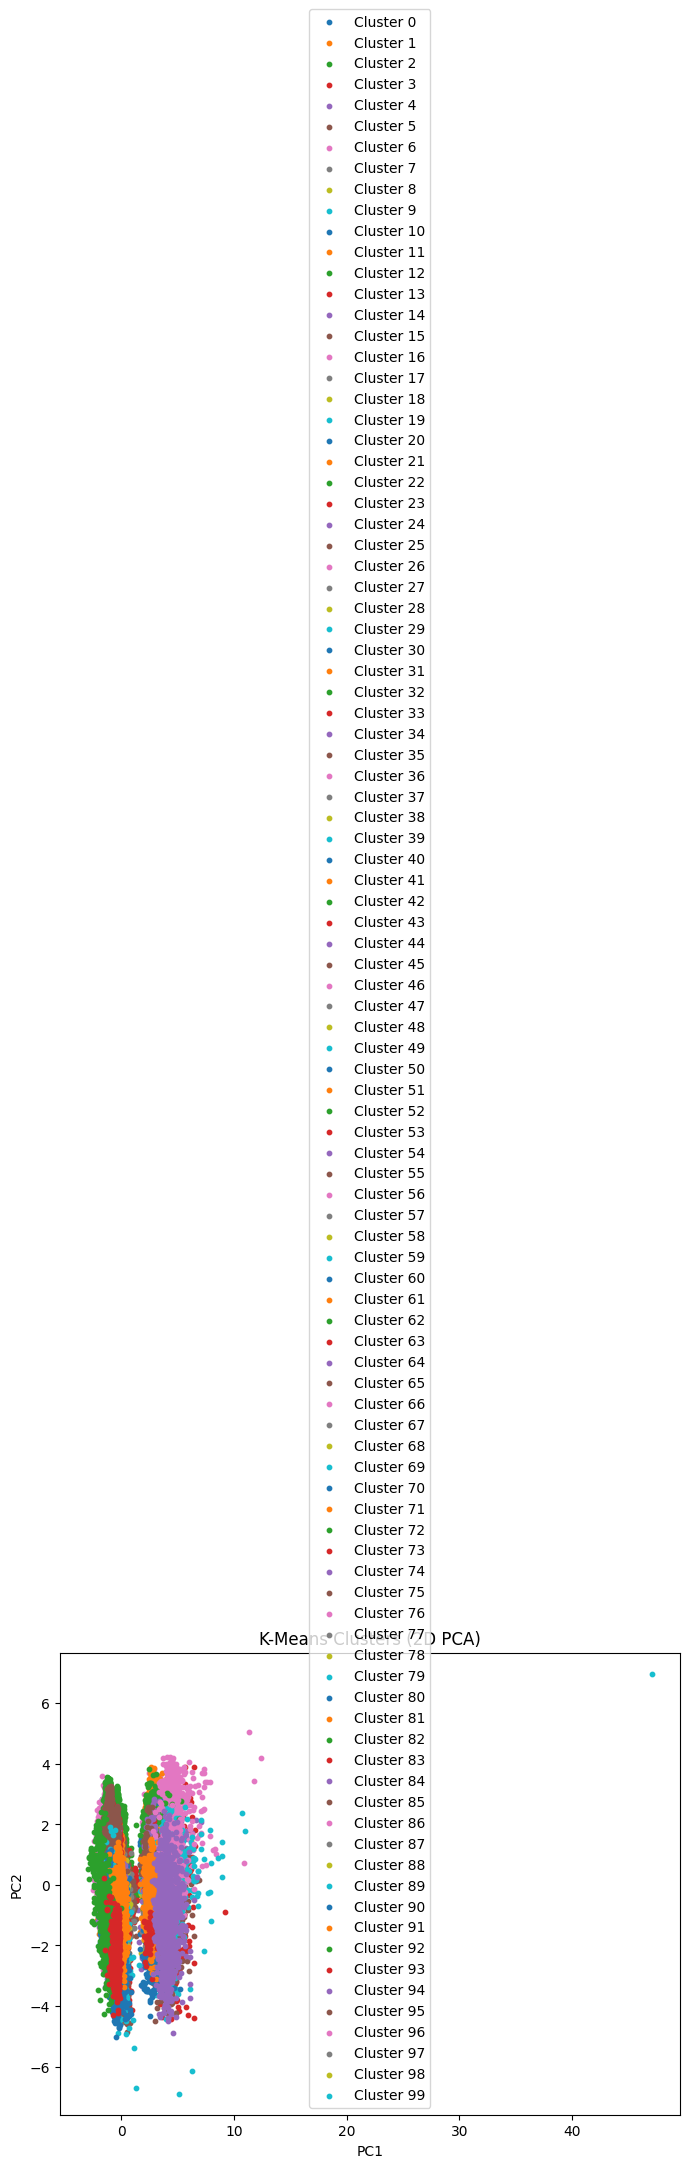

In [161]:

pca_2d = PCA(n_components=2)
data_2d = pca_2d.fit_transform(X)

plt.figure(figsize=(8,6))
for k in range(k_final):
    plt.scatter(data_2d[labels==k,0], data_2d[labels==k,1], label=f'Cluster {k}', s=10)
plt.title('K-Means Clusters (2D PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


### Algo 2: GMM 

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal

class GMM_FromScratch:
    """
    Gaussian Mixture Model implemented from scratch using the Expectation-Maximization (EM) algorithm.
    """
    def __init__(self, n_components=3, max_iter=100, tol=1e-4, random_state=42):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        np.random.seed(random_state)

    def _initialize_parameters(self, X):
        n_samples, n_features = X.shape
        # Randomly initialize means by sampling data points
        rand_indices = np.random.choice(n_samples, self.n_components, replace=False)
        self.means_ = X[rand_indices]

        # Initialize covariances as identity matrices
        self.covariances_ = np.array([np.cov(X, rowvar=False)] * self.n_components)
        
        # Initialize equal mixing coefficients
        self.weights_ = np.ones(self.n_components) / self.n_components

    def _e_step(self, X):
        """
        E-step: Compute the responsibility matrix (gamma_ik)
        """
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            rv = multivariate_normal(mean=self.means_[k], cov=self.covariances_[k], allow_singular=True)
            responsibilities[:, k] = self.weights_[k] * rv.pdf(X)
        
        # Normalize responsibilities across clusters
        total_resp = responsibilities.sum(axis=1, keepdims=True)
        responsibilities /= np.maximum(total_resp, 1e-10)
        
        return responsibilities

    def _m_step(self, X, responsibilities):
        """
        M-step: Update parameters (means, covariances, weights)
        """
        n_samples, n_features = X.shape
        Nk = responsibilities.sum(axis=0)
        
        # Update means
        self.means_ = (responsibilities.T @ X) / Nk[:, np.newaxis]
        
        # Update covariances
        self.covariances_ = np.zeros((self.n_components, n_features, n_features))
        for k in range(self.n_components):
            diff = X - self.means_[k]
            weighted_cov = (responsibilities[:, k][:, np.newaxis] * diff).T @ diff
            self.covariances_[k] = weighted_cov / Nk[k] + 1e-6 * np.eye(n_features)
        
        # Update weights
        self.weights_ = Nk / n_samples

    def _compute_log_likelihood(self, X):
        """
        Compute the log-likelihood of the data under the current parameters.
        """
        n_samples = X.shape[0]
        probs = np.zeros((n_samples, self.n_components))
        for k in range(self.n_components):
            rv = multivariate_normal(mean=self.means_[k], cov=self.covariances_[k], allow_singular=True)
            probs[:, k] = self.weights_[k] * rv.pdf(X)
        return np.sum(np.log(np.maximum(probs.sum(axis=1), 1e-10)))

    def fit(self, X):
        """
        Fit the GMM model to the data using EM.
        """
        X = np.asarray(X)
        self._initialize_parameters(X)

        log_likelihood_old = 0
        for i in range(self.max_iter):
            responsibilities = self._e_step(X)
            self._m_step(X, responsibilities)
            log_likelihood_new = self._compute_log_likelihood(X)

            if abs(log_likelihood_new - log_likelihood_old) < self.tol:
                break
            log_likelihood_old = log_likelihood_new

        self.responsibilities_ = responsibilities
        self.log_likelihood_ = log_likelihood_new
        self.labels_ = np.argmax(responsibilities, axis=1)
        return self

    def predict(self, X):
        X = np.asarray(X)
        responsibilities = self._e_step(X)
        return np.argmax(responsibilities, axis=1)


In [166]:
# Assuming df_pca_v2 is your PCA-reduced DataFrame
X = df_pca_v2.values

# Try multiple components (like you did for K-Means)
for n in range(2, 15):
    gmm_scratch = GMM_FromScratch(n_components=n, max_iter=100, tol=1e-4)
    gmm_scratch.fit(X)
    labels = gmm_scratch.labels_

    # Compute evaluation metrics manually (no sklearn)
    # Silhouette score approximation (simple version)
    from scipy.spatial.distance import cdist

    def silhouette_manual(X, labels):
        unique_labels = np.unique(labels)
        sil_scores = []
        for i in range(len(X)):
            same_cluster = X[labels == labels[i]]
            other_clusters = [X[labels == l] for l in unique_labels if l != labels[i]]
            a = np.mean(cdist([X[i]], same_cluster)) if len(same_cluster) > 1 else 0
            b = np.min([np.mean(cdist([X[i]], oc)) for oc in other_clusters])
            sil_scores.append((b - a) / max(a, b))
        return np.mean(sil_scores)

    sil_score = silhouette_manual(X[:500], labels[:500])  # sample for speed
    print(f"GMM (n={n}): Approx Silhouette={sil_score:.4f}")


GMM (n=2): Approx Silhouette=0.1493
GMM (n=3): Approx Silhouette=0.1995
GMM (n=4): Approx Silhouette=0.1995
GMM (n=5): Approx Silhouette=0.1995
GMM (n=6): Approx Silhouette=0.1995
GMM (n=7): Approx Silhouette=0.1995
GMM (n=8): Approx Silhouette=0.2062
GMM (n=9): Approx Silhouette=0.2062
GMM (n=10): Approx Silhouette=0.1609
GMM (n=11): Approx Silhouette=0.1780
GMM (n=12): Approx Silhouette=0.1780
GMM (n=13): Approx Silhouette=0.1115
GMM (n=14): Approx Silhouette=0.0983


### References

* K-Means Clustering Preprocessing Ideas: 
https://medium.com/@evgen.ryzhkov/5-stages-of-data-preprocessing-for-k-means-clustering-b755426f9932

* Comparing different clustering Algorithms for Mixed-Data: 
https://onlinelibrary.wiley.com/doi/full/10.1155/jpas/2242100?msockid=0098cfbf4b7661072c67db2d4a686047

* Understanding K-means, DBSCAN: 
https://www.youtube.com/watch?v=4b5d3muPQmA&t=1s, https://www.youtube.com/watch?v=RDZUdRSDOok

* Understanding GMM: 
